## Loading packages and setting up Jupyter notebook

In [1]:
import pdb 
import glob
import copy
import math

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
 
import missingno  # for visualizing missing data

In [2]:
# Load extensions
%load_ext memory_profiler

In [3]:
# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set seaborn options
sns.set()
# sns.set_context("notebook") 

In [4]:
#mpl.rcParams['figure.figsize'] = (10.0, 10.0) 

# Data 
A subset of the data is publicly available on Lending Club's website, but in order to access all the data I had to create an account. This data set is very comprehensive, it spans about 10 years (from 2007 – shortly after the firm's founding – to the present) and contains roughly 1.8 million observations for 150 variables.

## Inspecting data files

The data come in separate csv files that contain from a quarter up to multiple years of records. Let's inspect the individual files in the shell before importing them into pandas. 

In [5]:
# Print-out not shown because it is very long
# !head -2 data_raw/*.csv

This reveals that the first line contains comments and should thus be discarded when importing the data. The column names start in the second line.

## Importing data

In [6]:
# Get all the csv files in the data directory
files = glob.glob('data_raw/*.csv')

# Read those files into pandas
df_list = [pd.read_csv(file, header=1, low_memory=False) for file in files]

# Concatenate them into one DataFrame
all_data = pd.concat(df_list, ignore_index=True) 

# Get rid of the individual DataFrames
del df_list 

# Exploratory Data Analysis
Let's start with the dimension of our data set.

In [7]:
all_data.shape

(1873317, 151)

This reveals that we have about 1.8 million observations and 151 columns. Thus, let's start by getting rid of irrelevant observations and columns. We will then take a look at missing values in order to decide whether to impute them or to drop the whole column. 

Subsequently, we will explore how important loan outcomes have changed over time, and if we should discard data from the earliest years if it is too different from later observations. Once this is completed, we have arrived at the final set of observations and variables for the analysis, and we can start to explore distributions of individual variables as well as continue to explore relationship amongst other other variables.

## Dropping Duplicats
Now let's look if there are any duplicats in the data:

In [8]:
all_data.duplicated().sum()

0

No duplicats were found, so we don't have to take any action.

## Dropping irrelevant observations
To zoom in on only the relevant observation, let us take a look at the variable of interest, loan_status. This will allow us to filter out cases where the outcome is ambiguous:

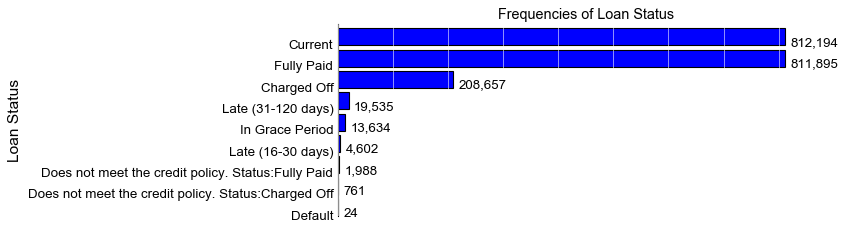

In [9]:
# sns.reset_defaults()
with plt.style.context('classic'): # Discard Seaborn defaults

    counts = all_data.loan_status.value_counts(ascending=True)  
    ind = np.arange(len(counts))  # y-axis

    fig, ax = plt.subplots(figsize=(8, 3))
    ax.barh(y=ind, width=counts)

    ax.set_title("Frequencies of Loan Status", fontsize=13)
    ax.set_ylabel("Loan Status", fontsize=14)

    ax.set_yticks(ind)  # Get rid of extra ticks on top and bottom
    ax.set_yticklabels(counts.index)
    
    fig.patch.set_facecolor('w')  # Change background color to white  
    ax.grid(axis='x', color='white', linestyle='-')
    sns.despine(bottom=True)
    ax.tick_params(axis='both', which='both',length=0, labelsize=12, labelbottom=False)
    # ax.tick_params(axis='bottom', labelsize = 0)
    for y_position, count in zip(ind, counts):  # Add frequencies
        plt.annotate(format(count, ','), xy=(count+10000, y_position))

plt.show()
plt.close()

As the above figure shows, the vast majority of loans fall into 3 classes: Loans that are still current, loans that were paid back completely, and loans that were written-off. Only a small fraction of loans (only 24, too small to be visible in the graph) are categorized as defaults (meaning that Lending Club has given up hope that they will ever be paid back). Furthermore, there is a small number of loans for which the loan status variable contains the string "does not meet the credit policy" in addition to specifying whether it is fully paid or charged-off. Unfortunately, there is no explanation anywhere what exactly this means. I will simply treat them as fully paid or charged off, and ignore the information about not meeting the credit policy, which seems to be a separate variable. However, I do not use the separate variable for prediction, because it is likely that this information only became available after the loan was issued (since presumably the loan would not have been issued if it had been known at the time that the borrower did not meet the credit policy).

The main question we need to decide is what exactly we want to predict.  I opt for a dichotomous classification into "charged off" and "default" versus "fully paid". For simplicity sake, I will call this variable "default". In other words, my category of default mainly includes loans that were charged off, as well as the few loans that are categorized by Lending Club as default.

I will ignore loans which are current or late – from still being in the grace period to up to 120 days late – because their status is yet indeterminate.  We have enough observations already, and thus any gain in accuracy from these additional observations would most likely be more than offset by the increase in variance due to the greater measurement error, because we do not have enough information yet to accurately classify them.

In [110]:
# Create target variable
all_data['default'] = np.NaN
all_data.loc[all_data.loan_status.str.contains('Fully Paid', na=False), 'default'] = 0 
all_data.loc[(all_data.loan_status.str.contains('Charged Off', na=False)|(all_data.loan_status=='Default')), 'default'] = 1

In [11]:
# Drop loans with indeterminate status
all_data = all_data.loc[all_data.default.notnull(),:]

## Indexing and Sorting Data
A natural index for the data is the "id" column. But first we need to make sure that it doesn't have any missing values.

In [12]:
all_data.id.isnull().sum()

0

It doesn't have any missing values, so we can use it. However, it would also be good to additionally index the data by the date that the loan was issued, so that we can sort and later potentially slice them by time. (Amongst other, this will come in handy later when looking at missing values, because we want to know if certain variables were simply not collected during certain time periods, or if they are missing for other reasons.)

Let's first take a look at how the issue data is formatted, so that we can more effectively parse it.

In [13]:
all_data.loc[:, 'issue_d'].head()

0    Dec-2011
1    Dec-2011
2    Dec-2011
3    Dec-2011
4    Dec-2011
Name: issue_d, dtype: object

Now we can set the issue date and loan ID as a hierarchical index, and then sort the data by date:

In [14]:
all_data['issue_d'] = pd.to_datetime(all_data.loc[:,'issue_d'], format='%b-%Y')

In [15]:
all_data = all_data.set_index(['issue_d', 'id']).sort_index()

## Dropping columns

Now that we have discarded irrelevant rows, let's discard irrelevant columns. Since we are starting with about 150 columns, this will make the EDA easier.

### Dropping constant or all-missing columns
Let's start by deleting columns which are either constant or for which all observations are missing:

In [16]:
# Find columns with 0 or 1 unique values
constant_or_missing = [col for col in all_data.columns if all_data.loc[:,col].value_counts().shape[0]<=1] 
print('Columns to be deleted:\n{}'.format(constant_or_missing))

# Delete those columns
all_data = all_data.drop(constant_or_missing, axis=1)

Columns to be deleted:
['member_id', 'pymnt_plan', 'policy_code', 'hardship_flag', 'hardship_type', 'deferral_term', 'hardship_length']


### Dropping columns with too many missing values
Now that we have discarded irrelevant rows and columns, let us take a closer look at the data. Firstly, let's see what percentage of each column is missing.

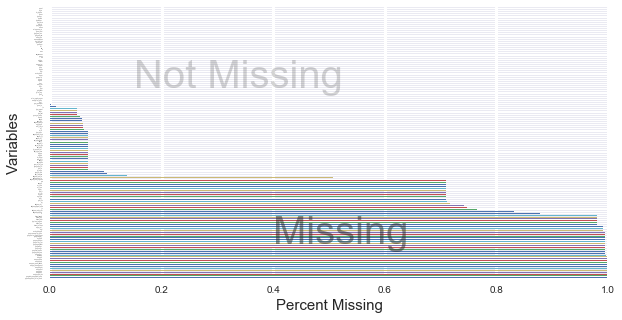

In [17]:
# Calculate the proportion of missing values for each variable
missing = (all_data.isnull().sum()/all_data.shape[0]).sort_values(ascending=False)

# Plot proportion of missing values for each variable 
missing.plot(kind="barh", figsize=(10, 5))
plt.xlim(0, 1)
plt.xlabel('Percent Missing', fontsize=15)
plt.ylabel('Variables', fontsize=15)
plt.tick_params(axis='y', length=0, labelsize = 0)
plt.grid(color="white", axis='x', linewidth=3)
plt.text(x=.15, y=100, s='Not Missing', fontsize=40, alpha=.2)
plt.text(x=.4, y=18, s='Missing', fontsize=40, alpha=.5)

plt.show()
plt.close()

Let us first focus on the big picture not worry about any individual variables. This reveals reveals an interesting pattern: Most variables cluster into groups with either no missing values (about a third of the variables), around 10% missing values (about a quarter), around 70% missing values (roughly 10% of variables), or almost all missing values (about a third of variables).

The fact that there are no variables that have between 15% and 65% missing values makes it easier for us to decide at what proportion of missing values we should draw a cut-off between dropping a variable and imputing missing values. I will choose 30% missing as the threshold, but any threshold between around 15% and around 65% would yield identical results.
    
This pattern could be due to the fact that, at certain points in time, additional batches of variables were starting to be collected. To look into this, let's aggregate the proportion of missing values by month and look for a time trend.

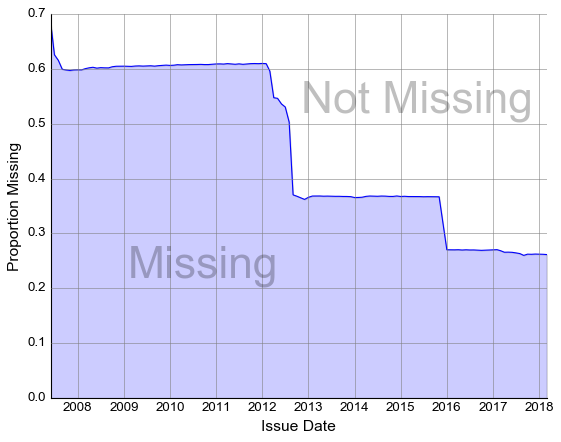

In [18]:
# Group-by month and calculate percentage of missing values
missing_by_year = all_data.groupby('issue_d').apply(lambda x: x.isnull().sum().sum()/(x.shape[0]*x.shape[1]))

with plt.style.context('classic'): # Discard Seaborn defaults
    fig, ax = plt.subplots()

    ax.plot(missing_by_year)
    ax.set(xlim=(min(missing_by_year.index), max(missing_by_year.index)), 
           ylim=(0, .7)) 
    ax.set_ylabel('Proportion Missing', fontsize=14)
    ax.set_xlabel('Issue Date', fontsize=14)
            
    ax.tick_params(length=0) 
    ax.fill_between(missing_by_year.index, 0, missing_by_year.values, alpha=.2)
    ax.grid(color='grey', linestyle='-')
    fig.patch.set_facecolor('w')       
    sns.despine()
    plt.text(x=missing_by_year.index[20], y=.22, s='Missing', fontsize=40, alpha=.25)
    plt.text(x=missing_by_year.index[65], y=.52, s='Not Missing', fontsize=40, alpha=.25)
    
plt.show()
plt.close()

It does indeed look like over time more and more variables were collected, and that these additional columns were for the most part added during three distinct time periods: In mid-2007 (only a few months after the first observations were collected), in 2012, and in late-2015.

To verify that it is in fact the same variables that are missing for a particular time period, we need to disaggregate these results by individual variables. If this shows that a particular variable has missing values that are distributed relatively evenly through time, we need to take a 2nd look at the meaning of the variable before dropping it to make sure that missingness does not simply denote that a variable is not applicable.  Obviously, if that was the case, there is no reason to drop it because it is not really missing – though we do have to find a way how to properly encode it. 
Conversely, if missingness for a particular variable mainly stems from the fact that it's observations were not collected during a substantial part of our sample period, we know that we can safely discard it. 

In the plot below, only variables that have at least one missing observation will be shown . Unfortunately, we still have too many columns to display the names of individual columns, so let's just focus on the big picture and plot smaller subsets later. Each column denotes a particular variable, and each row denotes an observation, ordered from earliest (top) to latest (bottom). Missing values are plotted as white, and non-missing values are plotted as black.  On the very right, there is a line graph that is supposed to show the number of non-missing values for each observation (ranging from 43 to 134), but due to the large number of observations graphed here, it is not very useful and can safely be ignored. 

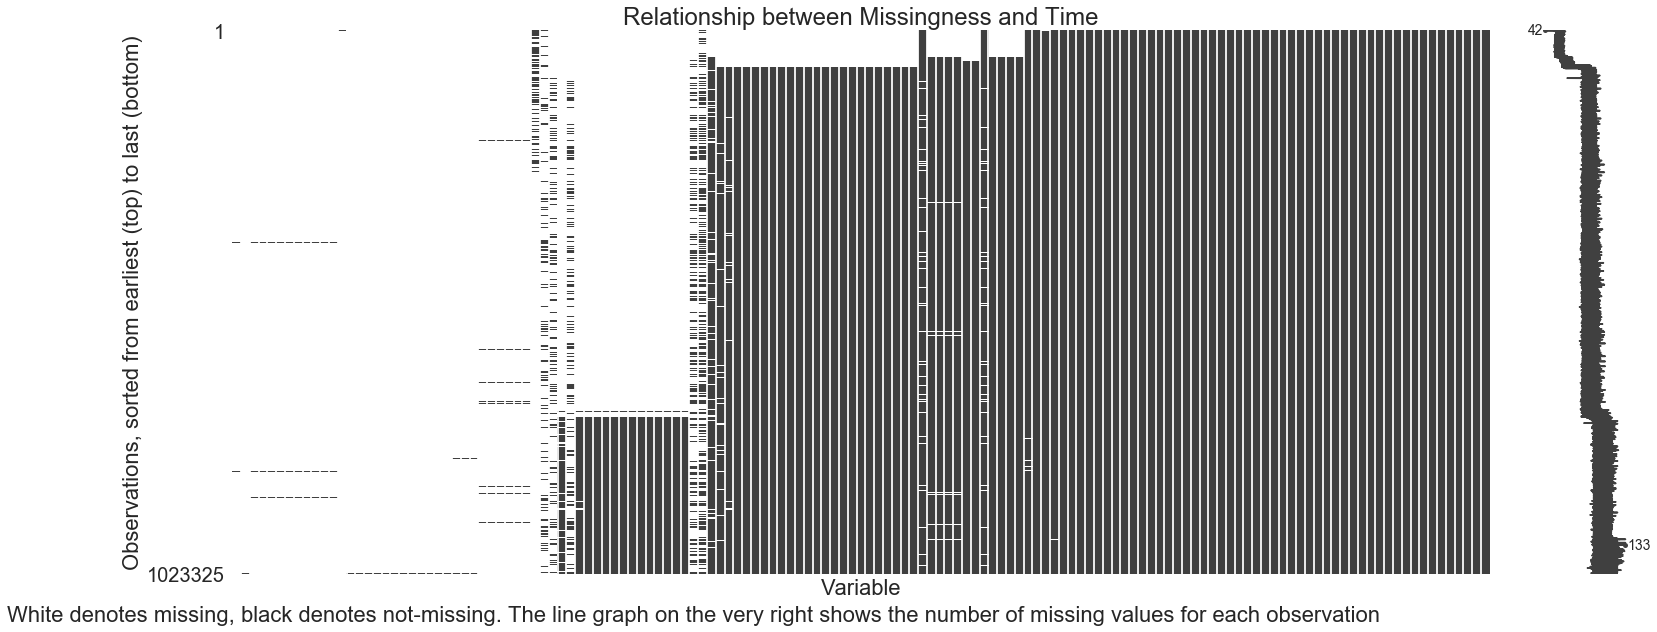

In [19]:
# Plot missing data
missingno.matrix(all_data.loc[:, missing.index])
plt.title('Relationship between Missingness and Time', \
          fontsize=24)
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize=22)
plt.xlabel('Variable', fontsize=22)
plt.figtext(x=0, y=.06, s="White denotes missing, black denotes not-missing. The line graph on the very right "
            "shows the number of missing values for each observation", fontsize=22)
plt.show()
plt.close()

This reveals that – with a few notable exceptions – most of the missingness is indeed caused by the fact that many variables were not collected over the whole sample period. At the same time, there are also a few variable with a substantial proportion of missing values that are distributed relatively evenly across time.

In order to be able to display the variable names, we need to split the variables up into several plots. Let's start with those variables that have the highest proportion of missingness: 

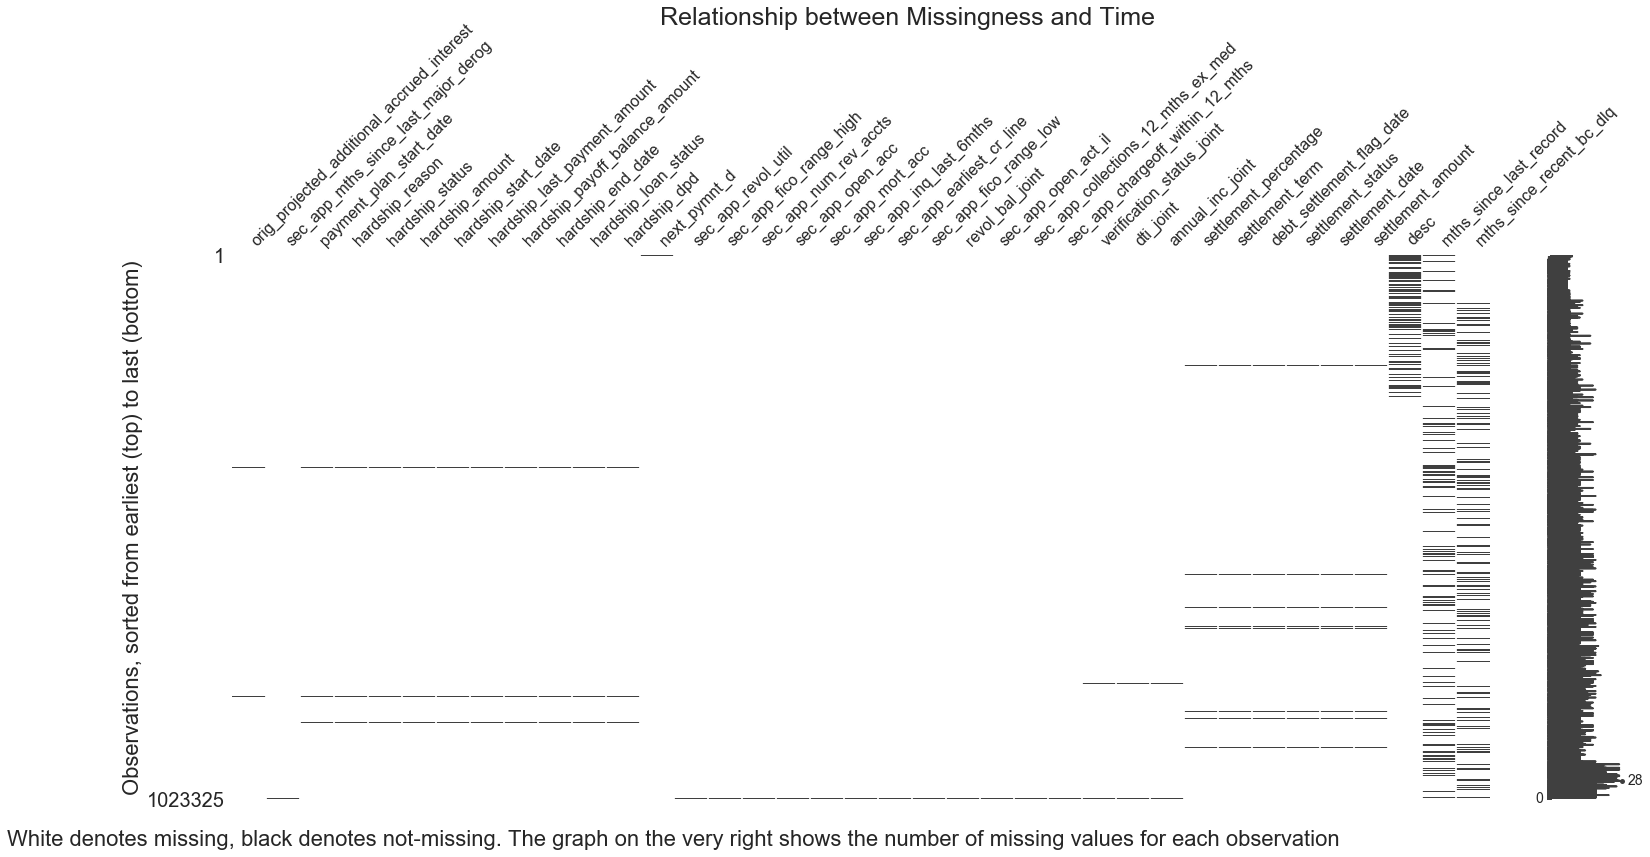

In [20]:
# Note that I don't explicitly exclude columns that have no missing values, because those will 
# automatically be discarded as irrelevant by missingno.
variables_to_plot_1 = missing[missing>.75].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_1])
plt.figtext(x=.5, y=1.2, s='Relationship between Missingness and Time', 
            fontsize=25, horizontalalignment='center')
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 22)
plt.figtext(x=0, y=.06, s='White denotes missing, black denotes not-missing. The graph on the very right '
            'shows the number of missing values for each observation', fontsize=22)
plt.show()
plt.close()

Most of these variables can safely be discarded since they were only collected for part of the sample period. The exceptions are the two rightmost variable, for which missingness is distributed relatively evenly across time. Thus, we will add them to a list of variables which to inspect later to make sure missingness doesn't actually stand for "not applicable".

In [21]:
# Create a list of variables to inspect later, and add the last two variables
variables_to_inspect = list(variables_to_plot_1[-2:])

# Create a list of variables to delete, and add all the plotted variables except the last two
variables_to_delete = list(variables_to_plot_1[:-2])
variables_delete = [variable for variable in variables_to_plot_1 if variable not in variables_to_inspect]

Now let's plot the remaining variables for which at least half of the values are missing. 

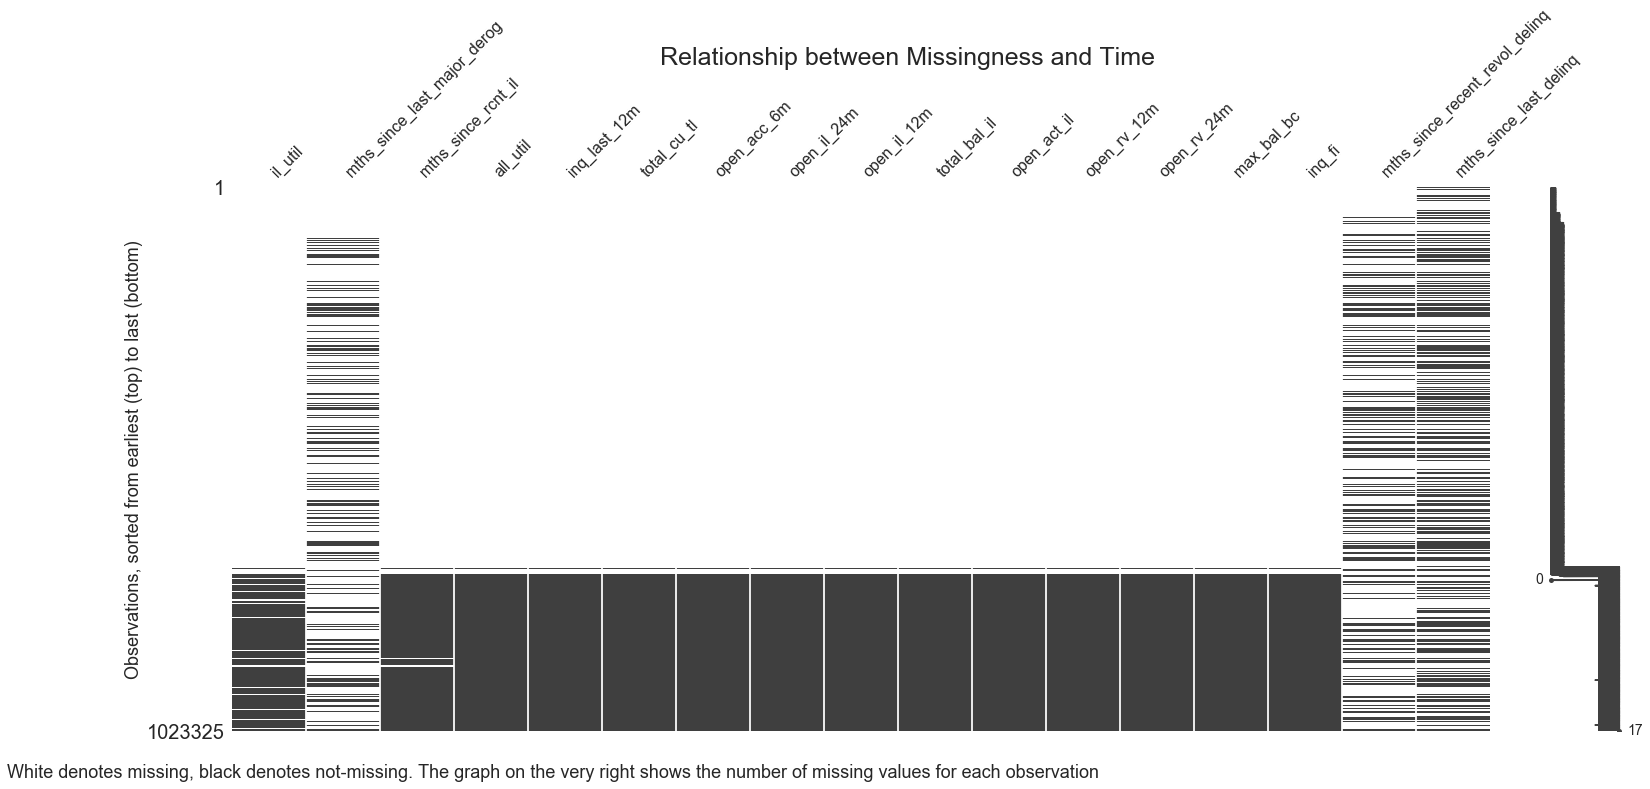

In [22]:
variables_to_plot_2 = missing[(missing <= .75) & (missing > .5)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_2])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.figtext(x=.5, y=1.05, s='Relationship between Missingness and Time', 
            fontsize=25, horizontalalignment='center')
plt.figtext(x=0, y=.06, s='White denotes missing, black denotes not-missing. The graph on the very right '
            'shows the number of missing values for each observation', fontsize=18)
plt.show()
plt.close()

Again, most of these variables were only collected for the last portion of the sample period, so we will discard them. However, for three variables missingness is distributed relatively evenly across time, so we will add them to the list of variables to inspect later.

In [23]:
# Add variables to list of variables to inspect later
variables_to_inspect.extend(['mths_since_last_major_derog', 'mths_since_recent_revol_delinq',
                            'mths_since_last_delinq'])

# Add variables to list of variables to delete
variables_to_delete.extend([v for v in variables_to_plot_2 if v not in variables_to_inspect])

Finally, let's plot missingness for variables that have less than 50% missing values. (We will ignore variables that have less than 0.5% missing values, because this is close enough to zero for our purposes to be ignored, and this reduces the number of variables sufficiently to fit them into one plot.)

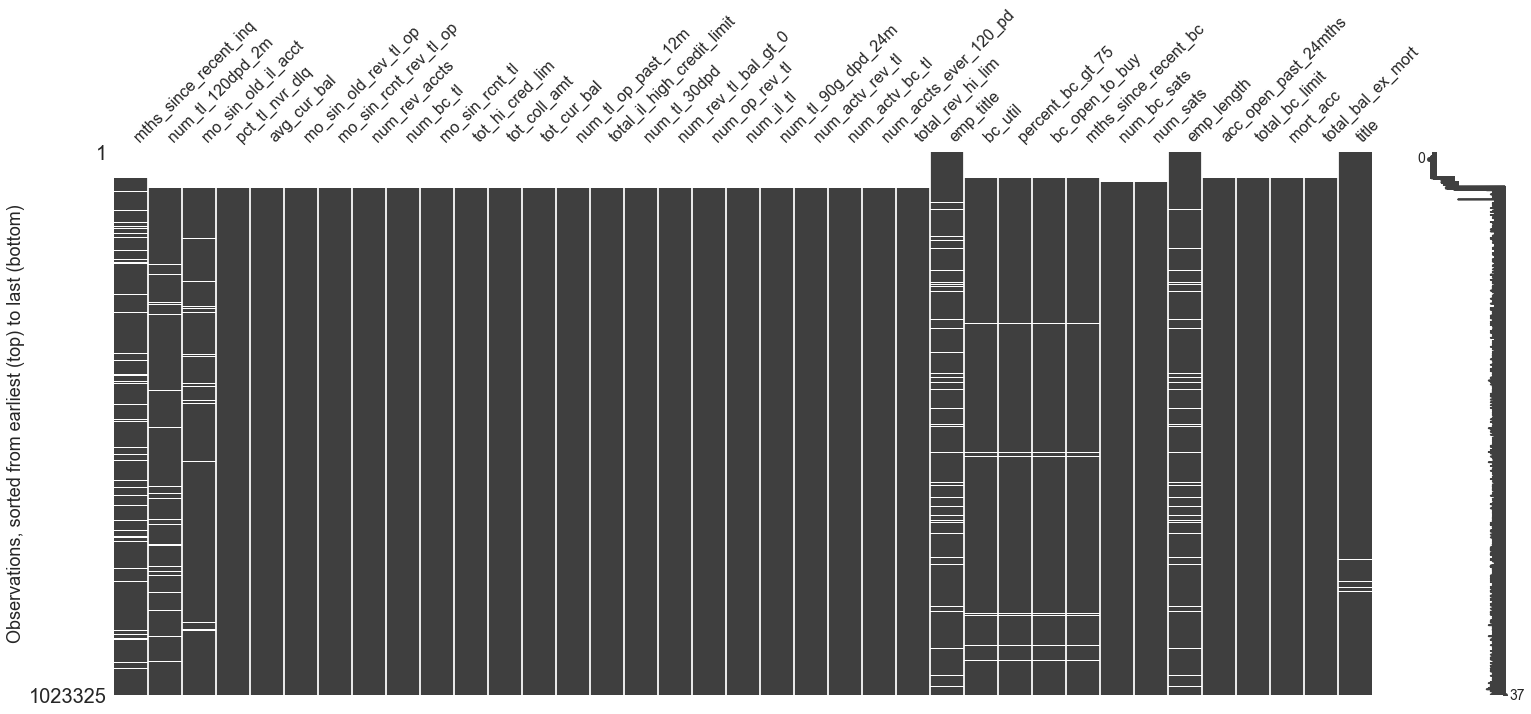

In [24]:
variables_to_plot_3 = missing[(missing < .50) & (missing > .005)].index # Select columns
missingno.matrix(all_data.loc[:, variables_to_plot_3])
plt.ylabel('Observations, sorted from earliest (top) to last (bottom)', fontsize = 18)
plt.show()
plt.close()

While for some of these variables were not collected at the very beginning of the sample periods, there is no need to drop them because their number of missing values (around 10%) is small enough to be imputed fairly reliably. (Furthermore, as we will see below, the earliest observations will be discarded from the sample anyway because Lending Club's business model was still in flux during its first years.)

Let us now inspect the variables we have singled out, to see whether missingness simply stands for "not applicable" instead of "value was not collected". Let's first print their names:

In [25]:
variables_to_inspect

['mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq']

All five variables refer to the number of months since a specific event which does not apply to all borrowers (e.g., experiencing a delinquency or a derogatory public record) happened. This explains why missingness for those variables is distributed relatively evenly across time: For those borrowers to which the particular event does not apply, the time since this event happened was encoded as missing. Unfortunately, there is no value in pandas that stands for "not applicable", so we will leave these values encoded as missing and decide on a better strategy once we know how exactly we are going to incorporate these variables into our model.

Since we decided not to drop any of these variables, our list of variables to drop is now complete, so let's go ahead and get rid of them:

In [26]:
# Drop variables with too many missing values
all_data = all_data.drop(variables_to_delete, axis=1)

#Print number of deleted variables
'{} variables were dropped'.format(len(variables_to_delete))

'49 variables were dropped'

### Dropping endogenous columns
It is also important that we drop columns that contain information that was not available at the time the loan was issued (e.g., whether the borrower experienced hardship during the payback period). Needless to say, failing to do so could give us an unfair edge if we included any of these variables in our model. (In the language of statistics, they are endogenous to our model since they are part of what we want to explain rather than part of what we can use for the explanation.) 

Unfortunately, the only way to identify those variables is to go through all variables by hand and consider their meaning. So let's print all column names:

In [27]:
list(all_data.columns)

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',

In [28]:
all_data.loc[all_data.funded_amnt != all_data.funded_amnt_inv,
             ['loan_amnt','funded_amnt','funded_amnt_inv','total_pymnt','total_pymnt_inv']] \
                .head()

loan_amnt  funded_amnt  funded_amnt_inv  total_pymnt  total_pymnt_inv
issue_d    id                                                                          
2007-06-01 70686     5000.0       5000.0              0.0  5619.762090             0.00
           71623     6500.0       6500.0              0.0  7373.904962             0.00
           72176     2525.0       2525.0            225.0  2904.498829           258.82
           72998     1000.0       1000.0              0.0  1155.600899             0.00
           73582     3500.0       3500.0            225.0  3719.431070           239.11

In [29]:
len(all_data.loc[all_data.funded_amnt != all_data.funded_amnt_inv,:])

100021

Looking up the meaning of the variables in the data dictionary reveals a number of variables were not known at the time the loan was issued: The most obvious ones relate to the amount and timing of the borrower's payments, and whether any late fees or even a debt settlement occurred. Those will all be deleted. 

Beyond those clear-cut cases, a few variables require more explanation: Firstly, we have information on the grade and sub-grade of the loan, which was calculated by a Lending Club.  I will discard these variables because I want to make my own prediction of a borrower's creditworthiness. 

The same is true of the interest rate, though things are slightly more complicated here: On the one hand, the interest rate borrowers receive is a summary of their other attributes that make them more or less likely to default, similar to the loan grade.  On the other hand, it also has an additional causal impact on their probability of default since it influences the monthly payments or the length of the payback period.  However, we can resolve this dilemma by directly including the monthly payment amount as well as the loan term as predictors. Since these are presumably the only channels through which the interest rate exerts a causal effect on the default rate, we can safely discard the interest rate. 

Note that it may make sense to keep the interest rate as well as the loan grade around for the rest of the EDA (e.g., to visualize the average default rate broken down by loan grade), so we will add them to a separate list of variables to be deleted later.

In [30]:
# Variables to delete now
endogenous = ['out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
              'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 
              'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 
              'debt_settlement_flag']

# Variables to delete later (keep around for EDA)
endogenous_2 = ['int_rate', 'grade', 'sub_grade']

Going through the meaning of our variables also reveals a number of irrelevant variables that we can delete: Most obviously, the URL of the listing data  does not tell us anything useful. The same is true of initial listing status (whether loan was sold whole or fractional), since this was decided randomly.

Finally, in addition to the amount that the borrower applied for, we also have information on both the amount that was funded overall, and the amount that was funded through Lending Club's investors. While neither the data dictionary nor the website explains how this discrepancy is funded, this need not concern us. We will only keep the overall amount that was funded, and discard the amount that was funded through investors, as well as the amount that the borrower originally applied for. Even though a discrepancy between those variables may contain useful information, it is better not to include it as a predictor: Both Lending Club and its investors presumably made their decision to only partially fund a loan request based on the same information we have available, and we want to make our own prediction. Thus, we will add those variables to the list of irrelevant variables to be deleted.

In [31]:
irrelevant = ['url', 'initial_list_status', 'loan_amnt', 'funded_amnt_inv',]

Now let's go ahead and delete both the irrelevant and the endogenous variables (except those endogenous variables we decided to keep around for the rest of the EDA).

In [32]:
# Deleting variables
all_data = all_data.drop(endogenous + irrelevant, axis='columns')

## Making sure variables are of the right type 

Now let's inspect the data type for each column. We will start with all variables that are currently floats.  The main thing that can be wrong here is that they are actually integers. Note that this only matters if the variable doesn't have any missing values. (Since the integer type cannot represent missing values, we have to store them as floats anyway.) So let's find all variables that are both integers and don't have any missing values.

In [33]:
np.unique(all_data.dtypes)

array([dtype('float64'), dtype('O')], dtype=object)

In [34]:
integers = [variable for variable in all_data.dtypes[all_data.dtypes==float].index
                if all_data.loc[:, variable].apply(float.is_integer).all()]
integers

['funded_amnt',
 'fico_range_low',
 'fico_range_high',
 'revol_bal',
 'last_fico_range_high',
 'last_fico_range_low',
 'default']

Let's convert those variables to integers, since these use less memory.

In [35]:
all_data[integers] = all_data.loc[:, integers].astype(int)

Now let's inspect the remaining variables, which are all of type "object". 

In [36]:
objects = all_data.dtypes[all_data.dtypes=='O'].index
all_data.loc[:, objects].head()

term int_rate grade sub_grade                   emp_title emp_length home_ownership  \
issue_d    id                                                                                                 
2007-06-01 70686   36 months    7.75%     A        A3                   Homemaker  10+ years       MORTGAGE   
           71623   36 months    8.38%     A        A5                         NaN   < 1 year           NONE   
           72176   36 months    9.33%     B        B3                         NaN   < 1 year           RENT   
           72998   36 months    9.64%     B        B4  Halping hands company inc.   < 1 year           RENT   
           73582   36 months   10.28%     C        C1                         NaN   < 1 year           RENT   

                 verification_status                                        loan_status purpose              title  \
issue_d    id                                                                                                        
2007-06-01 70686        Not Verified  Does not meet the credit policy. Status:Fully ...   other     Aroundthehouse   
           71623        Not Verified  Does not meet the credit policy. Status:Fully ...   other       Buying a car   
           72176        Not Verified  Does not meet the credit policy. Status:Fully ...   other    Car repair bill   
           72998        Not Verified  Does not meet the credit policy. Status:Fully ...   other            delight   
           73582        Not Verified  Does not meet the credit policy. Status:Fully ...   other  Wedding coming up   

                 zip_code addr_state earliest_cr_line revol_util last_credit_pull_d application_type  \
issue_d    id                                                                                          
2007-06-01 70686    068xx         CT              NaN        NaN           Feb-2015       Individual   
           71623    100xx         NY              NaN        NaN           Aug-2007       Individual   
           72176    100xx         NY              NaN        NaN           May-2007       Individual   
           72998    021xx         MA              NaN        NaN           Sep-2014       Individual   
           73582    100xx         NY              NaN        NaN           Feb-2013       Individual   

                 disbursement_method  
issue_d    id                         
2007-06-01 70686                Cash  
           71623                Cash  
           72176                Cash  
           72998                Cash  
           73582                Cash

Term, interest rate, and the revolving credit utilization rate can easily be converted to numeric by deleting the appended unit ("months", "%", and "%", respectively) from each value.

In [37]:
all_data['term'] = pd.to_numeric(all_data.term.str.replace(' months', ''))
for variable in ['int_rate', 'revol_util']:
    all_data[variable] = pd.to_numeric(all_data.loc[:, variable].str.replace('%', ''), errors='coerce')

The variables "earliest credit line" and "last credit pull date" are dates, so let's convert them to datetime objects.

In [38]:
for variable in ['earliest_cr_line', 'last_credit_pull_d']:
    all_data[variable] = pd.to_datetime(all_data.loc[:, variable], format='%b-%Y')

However, it is not these *absolute* dates that will be the best predictors; rather, what ultimately matters is how long ago – relative from the loan issue date – these events occurred. Thus, let's create a new features for this. We will only delete the absolute dates after completing the EDA, because we happen to need them again below, as we will see.

In [39]:
# Create new variables  with time difference
all_data['earliest_cr_line_days'] = \
    (all_data.reset_index(level='issue_d').issue_d.values
    - all_data.earliest_cr_line).dt.days

all_data['last_credit_pull_days'] = \
    (all_data.reset_index(level='issue_d').issue_d.values
    - all_data.last_credit_pull_d).dt.days    

The remaining variables are categorical. Before fitting our models, we will need to perform one-hot-encoding on them.  However, for the EDA it is more convenient to leave them as objects.

While we're at it, let's save the name of those variables for later.

In [40]:
categorical = ['grade', 'sub_grade', 'emp_length', '_ownership', 'verification_status', 'loan_status', 'zip_code', 'addr_state', 'application_type', 'disbursement_method' ]

Finally, let's have a look at all our numeric variables to make sure they are not actually ordinal or categorical. The reason we care about this is that we not only have to use different descriptive statistics and visualization techniques during the EDA, but we also need to transform them using one-hot-encoding before using them as predict yours in our machine learning models. The only exception is if the variable only takes on two unique values.

In [41]:
with pd.option_context('display.max_rows', 100):
    print(all_data.dtypes[all_data.dtypes!=object])

funded_amnt                                int32
term                                       int64
int_rate                                 float64
installment                              float64
annual_inc                               float64
dti                                      float64
delinq_2yrs                              float64
earliest_cr_line                  datetime64[ns]
fico_range_low                             int32
fico_range_high                            int32
inq_last_6mths                           float64
mths_since_last_delinq                   float64
mths_since_last_record                   float64
open_acc                                 float64
pub_rec                                  float64
revol_bal                                  int32
revol_util                               float64
total_acc                                float64
last_credit_pull_d                datetime64[ns]
last_fico_range_high                       int32
last_fico_range_low 

The only variable that is not actually numeric is our target variable, whether the borrower defaulted. However, since it only takes on two unique values, 0 or 1, this is indeed how we want to encode it.

## Univariate Distributions

Let's now inspect the (univariate) distribution for each variable with a boxplot. We will start with numeric variables. Two questions are of main interest here: Firstly, we want to examine if the distribution is skewed. If this is the case, it is usually best to apply a transformation to reduce this skew. Secondly, are there any outliers? Oftentimes, outliers are the result of a skewed distribution, and thus the same transformation that reduces skew frequently also makes outliers less severe. However, if this is not enough, we should take a closer look at the particular observation to determine if it looks like a measurement or data entry error has occurred. In this case, we may drop the offending observations.

A good way to examine skew and look for outliers is to graph the distribution for each variable with a boxplot.
(The exception are variables with only a small number (Less than 10) of unique observations, we will plot these with a histogram.) 

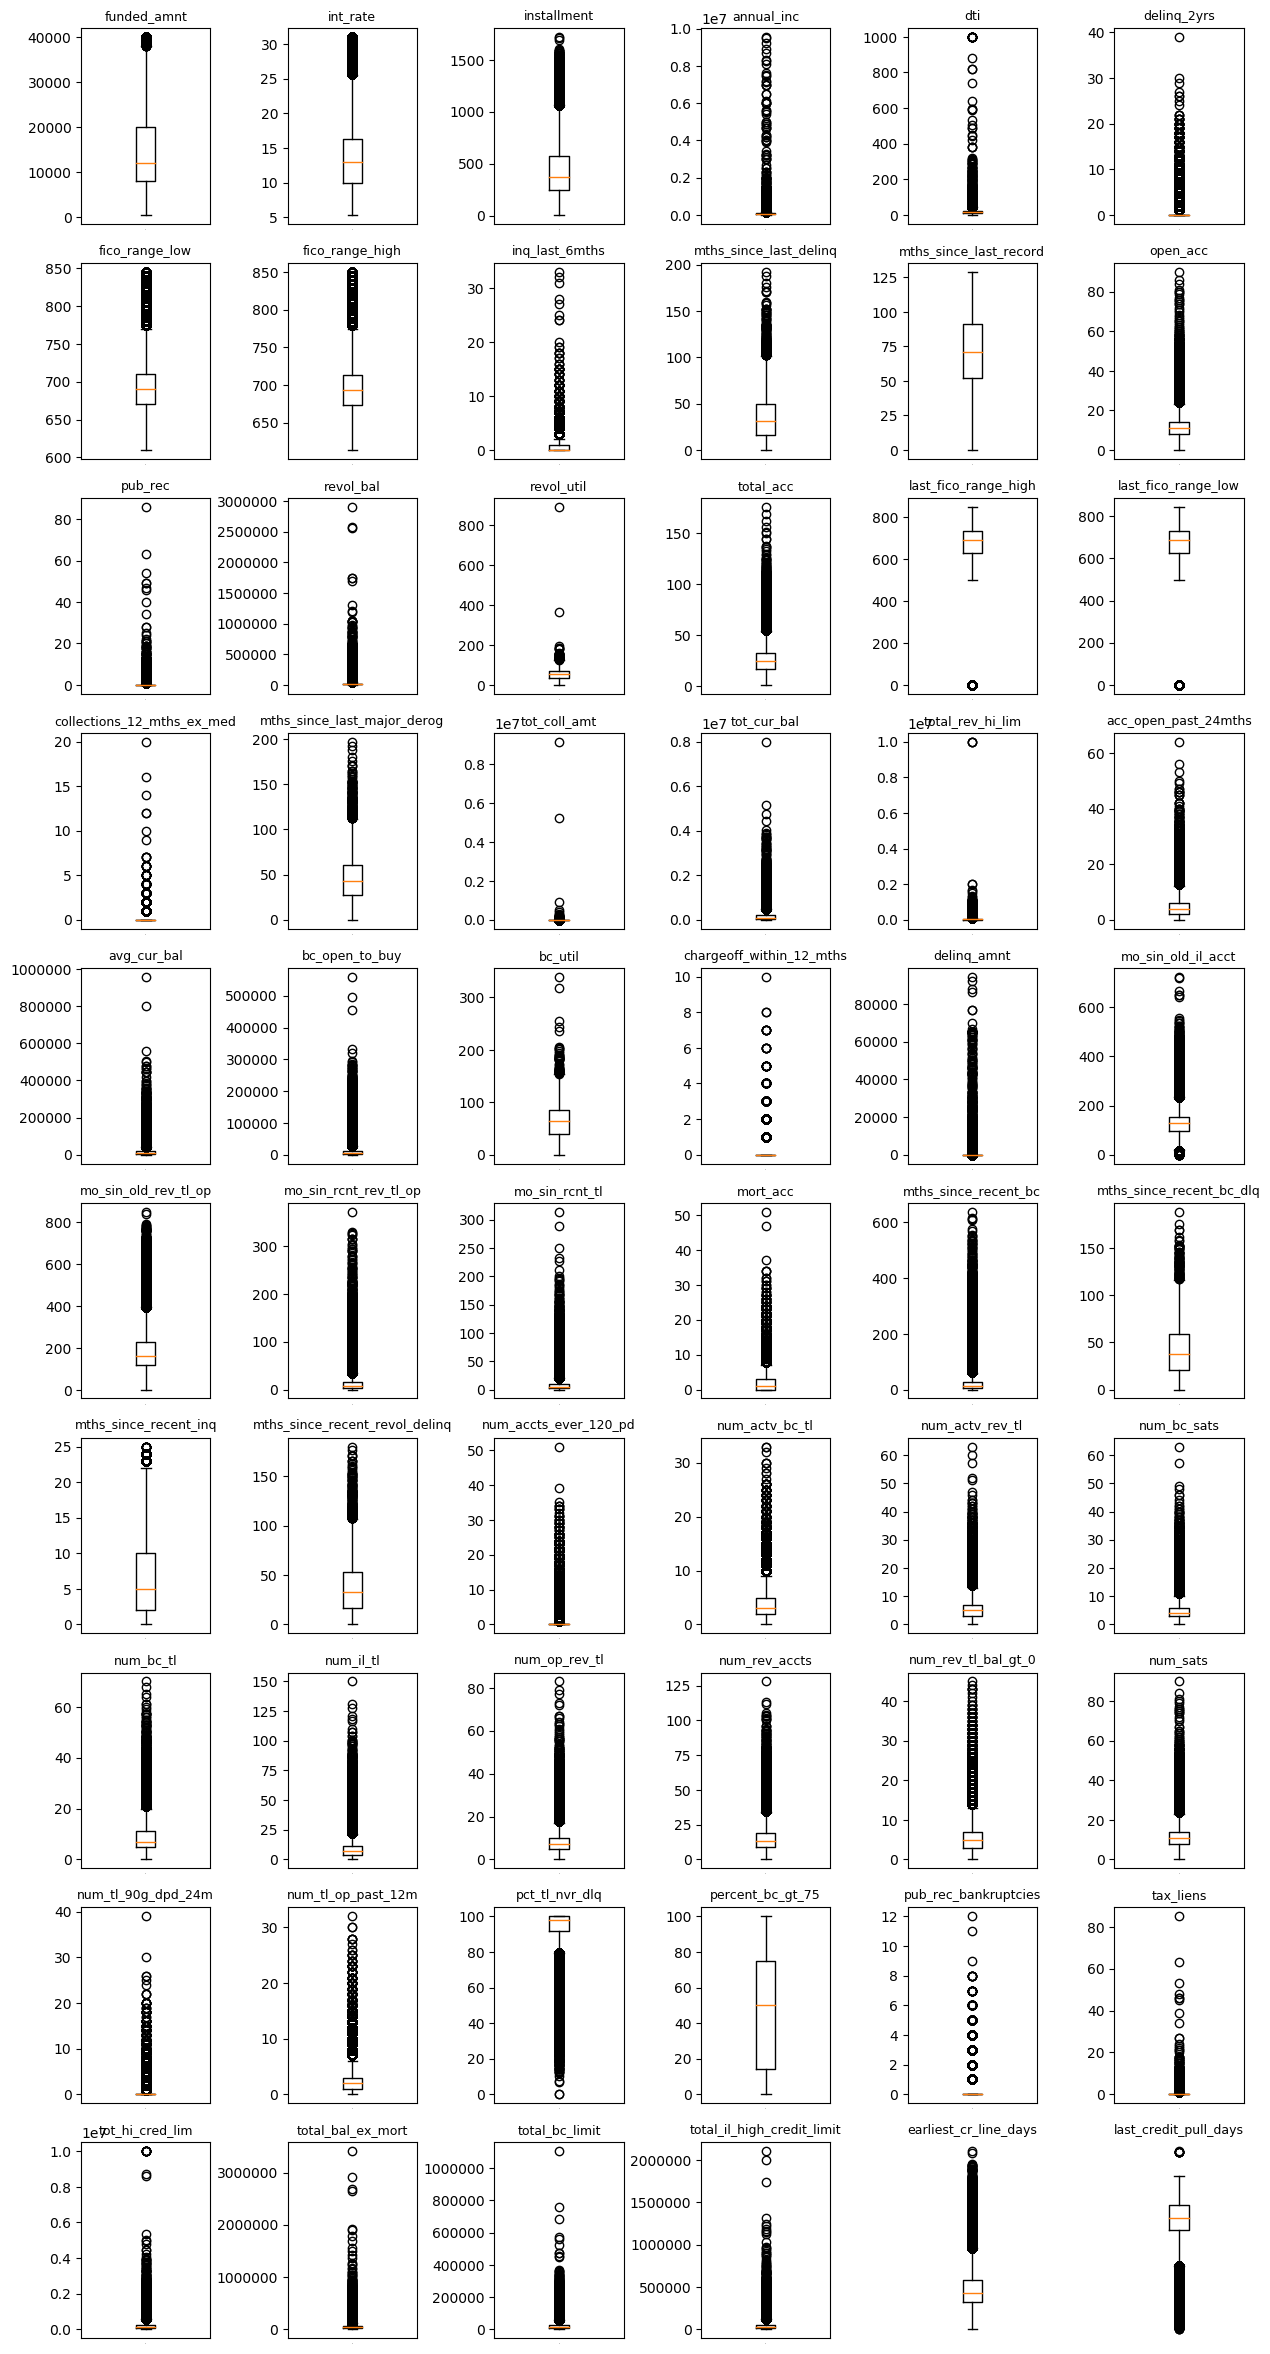

In [42]:
# get names of all the numeric variables
numerics = all_data.select_dtypes(include=[np.number]).columns.tolist()
# Count the number of unique values for each numeric variable
n_unique = all_data.loc[:, numerics].nunique()
# Add variables with more than 10 unique values to a list of variables to
# plot with a boxplot, otherwise to list for histogram
numerics_box = n_unique[n_unique >= 10].index
numerics_hist = n_unique[n_unique < 10].index  

# Make a boxplot for each
sns.reset_defaults()
fig, ax = plt.subplots(nrows=10, ncols=6, figsize=(15,30))
for subplot, variable in zip(ax.ravel(), numerics_box):
    subplot.boxplot(all_data.loc[all_data[variable].notnull(), variable])
    subplot.set_title(variable, fontsize=9)
    #Remove x-axis labels
    subplot.tick_params(axis='x', labelsize=0, length=0) 

# Delete the last subplots that we didn't need 
# (starting with the 5th in the last row)
for column_index in range(4, 6):
    ax[-1, column_index].axis('off')

# Increase spacing between plots    
fig.subplots_adjust(hspace=.2, wspace=.6)
 
plt.show()
plt.close()

Due to the large number of variables, we will not spend too much time looking at each single plot but rather just try to get a feel for the big picture and look for anomalies. The first thing that stands out is that most of our variables are right-skewed (have fat tails on the right). This is best addressed with a log-transformation. (All variables are positive, and while some contain zeros, we can simply add 1 to them before taking the log.) To automate this, I create a function that tests for each variable if a log-transformation would reduce the skew. If so, it applies the log-transformation (and moves the original variable to a new data frame in case we need it later).

Before we do that, however, we need to address one anomaly in the *last* FICO score range: For both its high and low, there are zeros, which is impossible since the score only ranges from 300-850. We will set these values as missing. But first let's count the percentage of zeros to make sure this doesn't introduce too many missing values.

In [43]:
print(round((all_data.last_fico_range_low<300).mean(), 4))
print(round((all_data.last_fico_range_high<300).mean(), 4))

0.0255
0.0002


It doesn't introduce more than 3% of additional missing values, so we can go ahead and set these zeros as missing.

In [44]:
for v in ['last_fico_range_high', 'last_fico_range_low']:
    all_data.loc[all_data[v]==0, v] = np.nan

Furthermore, though this isn't really visible from the box plots above, the debt-to-income-ratio (dti) contains a negative value, -1. This anomaly only became clear further below when I applied the log-transformation to the data.  However, to streamline the presentation of my analysis by avoiding having to repeat some steps with the error corrected, I already set this erroneous value to missing here.

The reason we can be confident that this is indeed a data-entry error is that the debt-to-income ratio cannot be negative. (It is true that we could think of wealth as negative debt, or we could imagine circumstances under which we could treat a person's income as negative. However, these definitions would not only be uncommon, but a negative value for the debt-to-income ratio also occurs only once in the whole data set, which seems virtually impossible if those definitions were used.)

Thus, let's set this value to missing.

In [45]:
all_data.loc[all_data.dti==-1, 'dti'] = np.nan

Many variables have a natural minimal of maximum.  For example, counts cannot be smaller than 0, and proportions cannot be larger than 100%. This is significant because we often use observable variables with such constraints as measures for latent variables that do not have those constraints. 

For example, we may use the number of derogatory public records as a measure for the latent variable of conscientiousness. Since  the number of derogatory public records is zero for most people, the difference between a person with one derogatory public record and a person with no derogatory public records is much larger than the difference between a person with two derogatory public records and a person with one derogatory public record. While we can apply a log-transformation to model this,

In [46]:
def mode_at_extremum(df):
    """
    Looks for variables where the mode occurs at the minimum or maximum.
    
    This is of interest because of censoring: Many variables have a natural
    minimum or maximum, e.g. 0 or 100%, respectively. 

    Parameters
    ----------
    df: pd.DataFrame
        Data frame whose variables to check .

    Returns
    -------
    tuple containing two lists
        First list contains names of variables whose mode occurs at the minimum.
        Second list contains names of variables whose mode occurs at the maximum.
    """
    
    # Get mode(s) for each variable in the data frame
    modes = df.mode()
    
    # Get minimum and maximum for each variable in the data frame
    minimum = pd.DataFrame(df.min())
    maximum = pd.DataFrame(df.max())
    
    # Loop over variables and save names of variables were mode occurs at an
    # extremum.
    mode_at_min = []  
    mode_at_max = []
    for variable in df:
        # Drop missing values from mode and try converting it to scalar
        try:
            mode_ = np.asscalar(modes.loc[modes[variable].notnull(), variable])
        # If a variable contains multiple modes, we are not interested in it
        except ValueError:
            print('{} contains multiple modes and will thus be ignored.'.format(variable))
        
        else:
            # Convert minimum and maximum to scalars
            min_ = np.asscalar(minimum.loc[variable])
            max_ = np.asscalar(maximum.loc[variable])
        
            # Test whether minimum or maximum occurs at the mode
            if (mode_ == min_):
                mode_at_min.append(variable)
            elif (mode_ == max_):
                mode_at_max.append(variable)
            
    return(mode_at_min, mode_at_max)

# numerics = all_data.select_dtypes(include=[np.number]).columns.tolist()
mode_at_min, mode_at_max = mode_at_extremum(all_data.loc[:, numerics])

In [47]:
def find_mixtures(df, variables, n_unique_threshold=10,
                  proportion_threshold=0.01, ratio_threshold=5, 
                  verbose=False):
    """
    Identify variables for which we should include a dummy for overly frequent unique values.

    For each variable in a DataFrame, identify unique values that occur so often that
    this variable is best modeled as being generated by a mixture process. I 
    operationalize such a value as occurring at least 10 times as often as would be 
    expected if all unique values occurred with the same frequency. For example, if
    the variable has 15 unique values, 
    
    A mixture process looks as follows:
    First, a Bernoulli variable determines if the variable takes on a particular discrete 
    value. This may be repeated for other particular discrete values.  If this is not 
    the case, the value is drawn from a different process such as a normal or poisson
    distribution. 

    Parameters
    ----------
    df: pd.DataFrame
        Data frame containing the variables to analyze.
    variables: list
        Variables, located in df, which to check. Usually these will be variables that
        have their mode at their minimum or maximum (e.g., the output from
        mode_at_extremum() ).
    n_unique_threshold: int
        The minimum number of unique values of variable must have in order to be 
        considered.
    proportion_threshold: numeric, optional
        The minimum proportion of observations in the samples that must have the most
        frequent value in order for the variable to be considered. This can be used to
        filter out variables where no value occurs frequently. Default: 1%.
    ratio_threshold: numeric, optional
        Threshold to use for the ratio of the most frequent to the second-most frequent 
        count. If it is exceeded, the variable will be treated as a deriving from a 
        mixture distribution. Default: 5
    verbose: bool
        If true, print out the ratio of the most frequent to the second-most frequent
        count for each variable. Default: False
        
    Returns
    -------
    list
        Names of variables that seem to derive from a mixture distribution.
    """

    mixtures = []
    # Go through all variables and look for mixtures
    for variable in variables:
        # Count unique values
        valuecounts = df.loc[:, variable].value_counts()
        
        # Skip variables whose number of unique values does not exceed the
        # supplied threshold
        if len(valuecounts) < n_unique_threshold:
            continue
        
        # Skip variables where no single value occurs frequently 
        if valuecounts.iloc[0] < proportion_threshold * len(df):
            continue
        
        # Compute ratio of occurrence of most-frequent to second-most frequent value
        ratio = valuecounts.iloc[0] / valuecounts.iloc[1]
        
        # Print ratio if requested
        if verbose==True:
            print(variable, ': ', ratio)

        # If ratio is greater than the threshold, save variable name
        if ratio > ratio_threshold:
            mixtures.append(variable)
            
    return(mixtures)
    
# mixtures_at_min = find_mixtures(all_data, mode_at_min, proportion_threshold=0.001)
# mixtures_at_max = find_mixtures(all_data, mode_at_max, proportion_threshold=0.001)
# mixtures_at_max

In [48]:
def add_mixture_dummies(df, mixture_min, mixture_max):
    # Initialize dictionary to store dummy variables
    mixture_dummies = {}
    # Create dummies for variables with mode at maximum
    for variable in mixture_max:
        dummy_name = 'max_' + variable
        mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                      df.loc[:, variable].max()
    
    # Create dummies for variables with mode at minimum
    for variable in mixture_min:
        dummy_name = 'min_' + variable
        mixture_dummies[dummy_name] = df.loc[:, variable] == \
                                      df.loc[:, variable].min()
    
    # Create data frame with all dummies
    mixture_dummies = pd.DataFrame(mixture_dummies)
    # pdb.set_trace ()
    # Add dummies to original data
    df = pd.concat([df, mixture_dummies], axis='columns')
    
    return(df)

# print(add_mixture_dummies(all_data, mixtures_at_min, mixtures_at_max).head())

In [49]:
def find_mixtures_add_dummies(df, dry_run=True, **kwargs):
    """
    Identify variables for which we should include a dummy for overly frequent 
    unique values. Print variable names or go ahead and add dummies.
    
    Identify numeric variables where we should add a dummy variable for the mode to
    model the extreme skewness that results from mixture processes such as
    zero-inflation. 
    
    For each numeric variable in a DataFrame, identify unique values that are 
    located at the minimum or maximum, and that occur so often that this variable is
    best modeled as being generated by a mixture process. The decision rule is
    based on the ratio of the most frequent count to the second-most frequent
    count. By default, this threshold is set to 5.

    The subset of mixture processes we are interested in here look as follows:
    First, a raw from a Bernoulli distribution decides if the variable takes on
    a particular discrete value (often 0 for counts or 100% for proportions). 
    If this is not the case, the variable's value is drawn from a different
    distribution such as a normal or poisson distribution. For simplicity, 
    this subtype of mixture process will simply be referred to as a mixture 
    process, since there is no more exact term.

    Parameters
    ----------
    df: pd.DataFrame
        Data frame to inspect and modify.
    dry_run: bool, optional
        Whether to simply print for which variables would be added, or whether
        to actually add those dummies to the input data frame. Default: only
        print variable names.
    **kwargs
        Additional arguments to change the defaults of find_mixture():
        n_unique_threshold, ratio_threshold, proportion_threshold, verbose.
    """

    # Consider only variables that are numeric
    numerics = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # First find variables where mode occurs at minimum or maximum
    mode_at_min, mode_at_max = \
        mode_at_extremum(df.loc[:, numerics])
    
    # Find which of those variables have an inflated number of 
    # minimum or maximum values
    mixtures_at_min = find_mixtures(df, mode_at_min, **kwargs)
    mixtures_at_max = find_mixtures(df, mode_at_max, **kwargs)
    
    
    # By default, only print for which variables a dummy will 
    # be added
    if dry_run == True:
        print('For the following variables, a dummy will be '
              'added for the MINIMUM:\n{}\n\n'
              'For the following variables, a dummy will be '
              'added for the MAXIMUM:\n{}' \
                 .format(mixtures_at_min, mixtures_at_max))
    
    # If specified, add dummies to original data and also return the
    # names of variables for which a dummy was added
    else: 
        return(add_mixture_dummies(df, mixtures_at_min, mixtures_at_max),
               mixtures_at_min, mixtures_at_max)

    
# Print names of variables for which dummies will be added
find_mixtures_add_dummies(all_data, proportion_threshold=0.001) 

For the following variables, a dummy will be added for the MINIMUM:
['delinq_2yrs', 'pub_rec', 'revol_bal', 'collections_12_mths_ex_med', 'tot_coll_amt', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit']

For the following variables, a dummy will be added for the MAXIMUM:
['pct_tl_nvr_dlq']


In [50]:
# Add dummies and save lists of variables for which we created dummies
all_data, min_dummies, max_dummies = find_mixtures_add_dummies(all_data, dry_run=False, proportion_threshold=0.001)
all_data.columns

Index(['funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
       'mths_since_recent_i

In [51]:
print(min_dummies, max_dummies)

['delinq_2yrs', 'pub_rec', 'revol_bal', 'collections_12_mths_ex_med', 'tot_coll_amt', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'total_il_high_credit_limit'] ['pct_tl_nvr_dlq']


Now we are ready to apply the log transformation where it reduces the skewness. Let's try to automate the process we go through manually when we examine a boxplot: What we do is compare the distance between median and upper quartile to the distance between median and lower quartile. If they are about equal, the distribution is symmetric; and the more these distances differ, the greater the distribution's skewness.

A good starting point to quantify skewness is thus the following measure, proposed by John Fox:

skewnesss_1 = $\frac{Upper Quartile - Median}{Median - Lower Quartile}$

This formula has the benefit that it does not rely on the mean: thus, it it is more robust to the outliers that acompany a large skewness than the third central moment $\sum (x_i - \mu)^3 $ is. Fox's measure is equal to one if the distribution is symmetric, between zero and one if the distribution is left-skewed (has wider tails on the left), and is between one and infinity if the distribution is right-skewed. Unfortunately, this scale is not ideal for our purposes: It does not allow us to easily determine which of two distributions has greater skew if one of them is left-skewed and the other is right-skewed. Thus, I simply take the log of this measure:

skewnesss_2 = log($\frac{Upper Quartile - Median}{Median - Lower Quartile}$)

To grasp the difference between these two measures, imagine two distributions that are mirror images of each others, i.e. have equal skewness but one is left-skewed while the other is right-skewed. The former measure would give them scores of, say, s and 1/s; but if we take logs, their scores would be s' and -s'. Thus, if all we care about is which distribution is less symmetrical and we don't care about the direction of this deviation, we can simply compare absolute values.

However, our measure will be undefined if a distribution is so skewed that the upper quartile is equal to the median, because this will result in log(0). Likewise, it will be undefined if the lower quartile is equal to the median, because this will result in a division by zero. To avoid this, we will simply replace these zeros by a very small value (0.000001). 

Unfortunately, this introduces another problem if the skewness is so extreme that all three quartiles fall onto the same value. (A common occurrence of this is a zero-inflated preocess, where almost all values are equal to zero.) Our above measure would conclude that this distribution is perfectly symmetrical (log(0.000001/log(0.000001) = log(1) = 0). We need to catch those cases and return a list of the variable names, so that we can exmine them by hand later.

In [52]:
def skewness(data, ignore_min=[], ignore_max=[], 
             verbose=True, n_threshold=5):
    """
    Returns the skewness of each variable in a Series or DataFrame.
    
    Skewness is operationalized as follows: 
    log((Upper Quartile - Median)/(Median - Lower Quartile)
    If the median falls on the same value as either the upper or lower quartile, the 
    resulting zero is replaced by a very small number in order to avoid taking the 
    log of zero or dividing by zero, respectively. If all three quartiles fall on 
    the same value, no skewness score is produced because our measure is not
    appropriate for such extremely skewed cases. 
    
    Parameters
    ----------
    data : Series or DataFrame
        Variable to transform.
    n_threshold : int
        Minimum number of unique values to compute skewness
    verbose : bool
        Whether to inform users for which variables the minimum or maximum was 
        discarded, and for which variables the skewness score is likely unreliable
        due to a low number of unique values.  This should only be turned off if
        those problematic variables have been removed beforehand. Default: True

    Returns
    -------
    
    
    If input is of type pd.Series:
        float
            skewness
    """
    
    # Inform the user for which variable the minimum or maximum value was ignored
    if verbose == True:
        if len(ignore_min) > 0:
            print('For the following variables the MINIMUM value was discarded when '
                  'computing the skewness:\n',
                  ignore_min)
        if len(ignore_max) > 0:
            print('\nFor the following variables the MAXIMUM value was discarded when '
                  'computing the skewness:\n',
                  ignore_max)
    
    # Make a copy of the input data to operate on
    x = copy.copy(data)
    
    # Compute number of unique values for each variable
    if verbose == True:
        n_unique = x.nunique()
    
    # Start by trying to treat the input as a SERIES:
    try:
        # First check whether we need to remove the mode. If so, set to missing
        if x.name in ignore_min:
            x.loc[x==x.min()] = np.nan
        elif x.name in ignore_max:
            x.loc[x==x.max()] = np.nan
        
        # If specified, make sure that there are enough unique values
        if (verbose == True) and (n_unique < n_threshold):
            print('\n The score for {} is unreliable because it only has {} '
                  'unique values.'
                      .format(x.name, n_unique))
        
        # Compute quartiles 
        quartiles = x.quantile(q=[.25, .5, .75])          
        upper_width = quartiles[.75] - quartiles[.5]
        lower_width = quartiles[.5] - quartiles[.25]
    
        # If the three quartiles do NOT fall on the same value, calculate skewness
        if (upper_width != 0) or (lower_width != 0):
            # If only the lower and middle quartile fall onto the same value, set 
            # their difference to a very small number to avoid introducing missing 
            # values due to division by zero.
            if lower_width == 0:
                lower_width = .000001
                # Do the same for the difference between upper quartile and median, 
                # since a zero here would prevent us from taking the log later.
            elif upper_width == 0:
                upper_width = .000001
            else: # Is there a better way of putting this?
                pass
                
            # Calculate skewness score
            skewness = np.log(upper_width / lower_width)
            # If skewness cannot be computed (for reasons other than all three 
            # variables falling onto the same value, which is addressed below),
            # a variable. 
            if not np.isnan(skewness):
                v_problem = [] # Make it a list for consistency with DataFrames
            else:
                v_problem = [x.name]  
                
        # If all three quartiles fall onto the same value, set skewness to missing
        else:
            skewness = np.nan        
            v_problem = []
                
    
    # If treating the input data as Series doesn't work, treat it as DATAFRAME
    except AttributeError:   # Because DataFrame doesn't have name attribute
        # Remove min or max from variables where we included a dummy for it
        for variable in x:
            if variable in ignore_min:
                x.loc[x[variable] == x[variable].min(), variable] = np.nan
            elif variable in ignore_max:
                x.loc[x[variable] == x[variable].max(), variable] = np.nan
                
        
        # The following code applies to both SERIES and DATAFRAMEs again:
        # Inform user about variables for which skewness is unreliable due to a
        # small number of unique values:
        if verbose ==True:
            low_n = n_unique < n_threshold
            if low_n.any():
                print('\nThe skewness score for the following variables is unreliable'
                      ' because they do not have enough unique values:\n',
                      n_unique[low_n])
        
        # Compute quartiles and distance between them
        quartiles = x.quantile(q=[.25, .5, .75])          
        upper_width = quartiles.apply(lambda col: col[.75] - col[.5])
        lower_width = quartiles.apply(lambda col: col[.5] - col[.25])
    
        # Flag location of variables where all three quartiles fall onto the same value, 
        # so that we can set skewness to missing later (because our measure cannot 
        # deal with such extreme cases.
        extreme_skew = (upper_width == 0) & (lower_width ==0)    
        v_no_skewness = x.columns[extreme_skew].tolist()
        # Inform user for which variables this is the case
        if verbose== True:
            print('\nThe following variables are too skewed to examine with our measure '
                  '(all three quartiles fall onto the same value):\n',
                  v_no_skewness)
            
        # If the difference between lower quartile and median is zero, set it to a very small
        # number to avoid introducing missing values due to division by zero.
        lower_width[lower_width == 0] = .000001
        # Do the same for the difference between upper quartile and median, since a zero
        # here would prevent us from taking the log later
        upper_width[upper_width == 0] = .000001

        # Calculate skewness score
        skewness = np.log(upper_width / lower_width)
    
        # Identify any missing values for skewness (Note that this is BEFORE
        # we manually added missing values for variables where all three quartiles 
        # fall onto the same value)
        if np.isnan(skewness).any():
            v_problem = skewness[skewness.isnull()].index.tolist()
                
            # Inform user about this 
            if verbose == True:
                print('Skewness for the following variables could not be '
                      'computed (for reasons other than all three quartiles'
                      ' falling onto the same value):\n'
                         .format(v_problem))
        else:
            v_problem = []  
            
        # Set skewness for variables where all three quartiles fall onto 
        # the same values to missing
        skewness.loc[extreme_skew] = np.nan
    
    return(skewness, v_problem)

In [53]:
def log_or_log1p(s):
    """ Returns the log of all strictly positive variables and the log(1+x) 
    of all non-negative variables. Ignores variables with any negative value. 
    
    Args: s, pd.Series
    
    """
    
    # Raise error for log(0) rather than producing NaNs
    with np.errstate(all='raise'):
        # Try taking log
        try:
            # Exclude missing values manually
            log = np.log(s[s.notnull()])
            log.name = 'log_' + s.name
                                         
            return(log)
        
        except FloatingPointError:
            pass  # To avoid nesting
        
        # If this fails, try taking log(1+x)
        try:
            log1p = np.log1p(s[s.notnull()]) 
            log1p.name = 'log1p_' + s.name
            return(log1p)        
        
        # If this still doesn't work, the variable contains 
        # negative values, so return None.
        except FloatingPointError:
            return(None)

# log_or_log1p(all_data.loc[:, 'dti']).head()

In [54]:
def transform_skewness(df, min_dummies, max_dummies,
                       n_threshold_ignore=3, n_threshold_warn=10, 
                       take_log=[], dry_run=True):
    """Applies log-transformation to each variable in a DataFrame where it 
    reduces skewness.

    Only numeric variables with at least 10 unique values are considered (since
    
    Parameters
    ----------
    df : pd.DataFrame
        Data to diagnose or transform
    min_dummies : list
        Variables for which all minimum values should be ignored when
        computing skewness.
    max_dummies : list
        Variables for which all maximum values should be ignored when
        computing skewness.
    n_threshold_ignore : int
        Specifies the minimum number of unique values a variable must 
        exceed in order to be considered.
    n_threshold_warn : int
        Specifies the minimum number of unique values a variable must
        exceed so that the user is not warned to examine it manually.
    take_log : list, optional
        Variables for which you take the log without examining them first.
        This is particularly useful after already having performed a 
        manual diagnosis during the dry-run. Default: Empty list.
    dry_run : boolean
        If False, performs the transformations.  If True, prints which
        transformations would be performed, along with some additional 
        information. Default: False.
    
    Returns
    -------
    If dry_run == False:
        df_new : pd.DataFrame
            Transformed data
        df_deleted_v: pd.DataFrame
            Deleted (untransformed) variables
        
    If dry_run == True:
        None
        
    """
    
    # Select only relevant variables
    # ------------------------------
    
    # Get names of all the numeric features
    v_numeric = all_data.select_dtypes(include=[np.number]).columns.tolist()
    # Count the number of unique values for each numeric variable
    n_unique = df.loc[:, v_numeric].nunique()
    # Ignore variables with very low counts (and save their names)
    v_very_low_count = n_unique.loc[n_unique <= n_threshold_ignore]
    
    # Make a list of transform  candidates that excludes variables that are
    # not numeric or have very low counts of unique values
    transform_candidates = [v for v in v_numeric if v not in v_very_low_count]
    
    # Save variables with moderately low number Unique values, so that
    # we can suggest to examine them manually
    v_low_count = n_unique.loc[(n_unique <= n_threshold_warn) & 
                               (n_unique > n_threshold_ignore)]
    
    
    # Try log transformation
    # ----------------------
    
    # Calculate skewness before transformation (if we added a dummy for
    # min or max, ignore those values and calculate skew for other values only)
    skew_level, v_problem_level = skewness(df.loc[:, transform_candidates], 
                                          ignore_min=min_dummies, 
                                          ignore_max=max_dummies,
                                          n_threshold=n_threshold_ignore,
                                          verbose=False)

    # Count number of outliers before transformation
    # TODO
    
    # Create list to store transformed variables if they are less skewed
    v_to_transform = []
    # Create a list of the variables to delete because they were transformed
    v_to_delete = []
    # Create list to store variables where transformation failed due to 
    # negative values
    v_negative = []
    # Create list to store variables where transformation failed for 
    # other reasons
    v_trans_failed = []
    # Create a list to store variables where user-specified to take the log
    # either way but it was not possible.
    v_take_log_problem = []
    # Create a list to store variables where a problem occurred computing the
    # skewness (other than the three quartiles falling onto the same value)
    v_problem_log = []
    # Create lists to store variables where skewness couldn't be computed
    # because the three quartiles fall onto the same value
    v_no_skewness_both= []  # Neither could be computed
    v_no_skewness_level = []  # Skewness for level couldn't be computed
    v_no_skewness_log = []  # Skewness for log couldn't be computed
    
    # Create lists of variables for which to ignore the minimum or 
    # maximum for the log-transformed variables
    min_dummies_log = [prefix + v for v in min_dummies 
                       for prefix in ['log_', 'log1p_']]
    max_dummies_log = [prefix + v for v in max_dummies
                       for prefix in ['log_', 'log1p_']]
        
    # Loop over all the numeric variables, apply transformations, and determine
    # what minimizes the skewness
    for v in transform_candidates:
        col = df.loc[:, v]  # Extract column 
        
        # Try taking the log
        log = log_or_log1p(col)         
        
        # If the user specified to take the log either way, do the following:
        # Save the transformed variable, so we can add it to data
        if v in take_log:
            v_to_transform.append(log)
            # Save name of untransformed variable, so we can delete it
            v_to_delete.append(v)
            assert len(v_to_transform)==len(v_to_delete) 
            # Go on to the next variable
            continue
            
        # If taking the log was possible, calculate skewness. 
        # (If we added a dummy for min or max, ignore those valuesa
        # and calculates skewness only for the other values)
        if log is not None:
            # Create updated lists of variables for which to ignore
            # minimum or maximum
            skew_log, v_problem = skewness(log, verbose=False, 
                                           n_threshold=n_threshold_ignore,
                                           ignore_min=min_dummies_log,
                                           ignore_max=max_dummies_log)
            # Add names of variables where a problem occurred to the list
            v_problem_log.extend(v_problem)
                                                                   
        # If transformation wasn't possible, check if it's due to any 
        # negative values. Then save name of offending variable.
        else:
            #  Since we're taking log(1+x), the threshold is -1, not 0.              
            if df.loc[:, v].min() <= -1:    
                v_negative.append(v)
            else:
                v_trans_failed.append(v)
            # If the user-specified to take the log either way, note
            # that it wasn't possible
            if v in take_log:
                v_take_log_problem.append(v)
            # Move onto the next variable
            continue
            
        # (Execute this block only if log-transformation was successful)    
        # Determine if transformation decreased skew
        # Compute absolute value of skewness
        abs_skew_level = abs(skew_level[v])
        abs_skew_log =abs(skew_log)

        # If log-transformation decreases skew do the following steps:
        # (Remember that if one scalar is NaN, x<y will return False) 
        if abs_skew_level >= abs_skew_log:
            # Save the transformed variable, so we can add it to data
            v_to_transform.append(log)
            # Save name of untransformed variable, so we can delete it
            v_to_delete.append(v)
            assert len(v_to_transform)==len(v_to_delete) 

        # If transformation doesn't decrease skewness, proceed to the next variable
        elif abs_skew_level <= abs_skew_log:
            continue

        # If skewness can't be calculated, save variable name
        elif np.isnan(abs_skew_level) and np.isnan(abs_skew_log):
            v_no_skewness_both.append(v)
        elif np.isnan(abs_skew_log):
            v_no_skewness_log.append(v)
        # If we only have a skewness score for the log, keep log not level
        elif np.isnan(abs_skew_level):
            v_no_skewness_level.append(v)
            # Save the transformed variable, so we can add it to data
            v_to_transform.append(log)
            # Save name of untransformed variable, so we can delete it
            v_to_delete.append(v) 
            
            
    # Print and return results
    # ------------------------
    output_dict = {} # Dictionary with the results to return
    
    # Inform user about important issues
    output_dict['skewness_problem'] = v_problem_level + v_problem_log
    if (len(v_problem_level) > 0) and (len(v_problem_log) > 0):
            print('A problem occurred when trying to compute the skewness '
                  'of the following variables (even though their quartiles '
                  'do NOT all fall under the same value):\n{}\n'
                     .format(v_problem_level + v_problem_log))
            
    output_dict['transformation_failed_other_reasons'] = v_trans_failed
    if len(v_trans_failed) > 0:
        print('The following variables cannot be transformed, even though '
              'they do NOT contain values less than or equal to -1:\&{}\n'
                  .format(v_trans_failed))
        
        
    # Inform user about less important issues (print only if specified)
    # related to the number of unique observations
    output_dict['very_low_unique'] = v_very_low_count
    if (dry_run == True) and (len(v_very_low_count) > 0):
        print('The following variables will be ignored because they contain'
              ' less or equal than {} unique values:\n{}\n'
                 .format(n_threshold_ignore, v_very_low_count))

    output_dict['low_unique'] = v_low_count
    if (dry_run == True) and (len(v_low_count) > 0):
        print('The following variables contain a low number of unique values. '
              'It might be best to examine them manually if the applied '
              'transformation makes sense, or if it is be better to model '
              'them as categorical: \n', v_low_count, '\n')

    # Issues related to log-transformation
    output_dict['below_negative_1'] = v_negative
    if (dry_run == True) and (len(v_to_delete) > 0):
        print('The following variables cannot be transformed because they '
              'contain values less than or equal to -1:\n{}\n'
                 .format(v_negative))
    # If the log-transformation failed even though the user-specified that
    # it should be conducted either way, notify the user (even if dry-run
    # is False)
    if (len(v_take_log_problem) > 0):
        print('Even though it was specified to take the log of the following'
              ' variable either way, it wasn\'t possible:\n {}\n'
                  .format(v_take_log_problem))

    # Issues related to skewness
    output_dict['all_3_quartiles_equal_both'] = v_no_skewness_both
    if (dry_run == True) and (len(v_no_skewness_both) > 0):
        print('The following variables will be ignored because skewness couldn\'t'
              ' be computed (all three quartiles fall onto the same '
              'value) for both the level and the log:\n{}\n'
                 .format(v_no_skewness_both))

    output_dict['all_3_quartiles_equal_log_only'] = v_no_skewness_log
    if (dry_run == True) and (len(v_no_skewness_log) > 0):
        print('The following variables will be left untransformed because '
              'skewness could only be calculated for the level, but not the '
              'log:\n{}\n'
                 .format(v_no_skewness_log))

    output_dict['all_3_quartiles_equal_level_only'] = v_no_skewness_level
    if (dry_run == True) and (len(v_no_skewness_level) > 0):
        print('The following variables will be transformed, but note that '
              'skewness could only be calculated for the log:\n{}\n'
                 .format(v_no_skewness_level))

    # Print how many variables will be transformed
    print('Number of variables to be transformed: {}\n'
          'Number of variables left unchanged: {}\n'
              .format(len(v_to_delete), 
                  len(transform_candidates) - len(v_to_delete)))
    
    # If specified, print which variables will be transformed
    if dry_run == True:
        print('The following variables will be transformed:\n{}\n\n'
              'The following variables will NOT be transformed:\n{}'
                .format(v_to_delete,
                        [v for v in transform_candidates 
                         if v not in v_to_delete]))

    # If dry-run is True, only return dictionary with results
    if dry_run == True:
        return(output_dict)

    
    # Otherwise, modify original data
    # --------------------
    
    else:
        # Remove level of variables where log decreased skew, and save them to a 
        # separate data frame (in case we need them later)
        df_deleted_v = df.loc[:, v_to_delete]
        df_new = df.drop(v_to_delete, axis='columns')

        # Create a new data frame with the logs of the deleted variables
        df_logs = pd.concat(v_to_transform, axis='columns')
        # Add these transformed variables to our new data frame
        df_new = pd.concat([df_new, df_logs], axis='columns')

        return(df_new, df_deleted_v, output_dict)


# Get diagnostics about what transformations will be performed
log_diagnostics_before = transform_skewness(all_data, 
                                            min_dummies=min_dummies, 
                                            max_dummies=max_dummies)

The following variables will be ignored because they contain less or equal than 3 unique values:
term       2
default    2
dtype: int64

The following variables contain a low number of unique values. It might be best to examine them manually if the applied transformation makes sense, or if it is be better to model them as categorical: 
 acc_now_delinq               8
chargeoff_within_12_mths    10
num_tl_120dpd_2m             5
num_tl_30dpd                 5
dtype: int64 

The following variables cannot be transformed because they contain values less than or equal to -1:
['last_credit_pull_days']

The following variables will be ignored because skewness couldn't be computed (all three quartiles fall onto the same value) for both the level and the log:
['pub_rec', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'pub_rec_bankruptcies']

Number of variables to be transformed: 32
Number of variables left unchanged: 31

The fol

First off, we see that our target variable – default – will be ignored because it has too few categories. That's good, otherwise we would have to manually exclude it.

Now let's inspect the variables that have between 5 and 10 unique observations.  Four variables fall within this category: The number of accounts delinquent, the number of charge-offs within the last 12 months, and two variables about the number of accounts currently past due. 

There is no compelling reason to model either of these with dummy variables (except for when these variables are zero, as discussed above). Thus, we don't need to worry about anything here.

If we now turn our attention to the number of variables for which the log-transformation failed because of values smaller than one, we see that this was the case for only one variable, the time span between the loan origination and the last time the credit score was pulled. Remember that we computed this variable ourselves, so let's take a look at the original variable – The date of the last credit pull – to make sure we did not mess up the sign:

In [55]:
all_data.last_credit_pull_d.head()

issue_d     id   
2007-06-01  70686   2015-02-01
            71623   2007-08-01
            72176   2007-05-01
            72998   2014-09-01
            73582   2013-02-01
Name: last_credit_pull_d, dtype: datetime64[ns]

This indeed reveals that the issue date (which we can see as part of the index) is for many cases *before* the date of the last credit pull. This means that we have to discard the score from the last credit pull, because it contains information not available at the time the loan was issued (and is thus endogenous). Likewise, the variable that tells us how long ago the last credit pull occurred, relative to the issue date of the loan, becomes irrelevant. Thus, we will add these variables to the list of variables to delete.

Fortunately, a look at the data dictionary reveals that there is a separate credit score from the time when the loan was issued.

In [56]:
# Delete variables
all_data = all_data.drop(
    ['last_fico_range_low', 'last_fico_range_high', 'last_credit_pull_days'],
    axis='columns')

The final point we need to address before carrying out the log-transformations is the set of variables for which we were unable to compute the skewness for both the level and the log.  This occured when variables were so skewed that all three quartiles fall onto the same value. We tried to ameliorate this problem by adding dummy variables for the mode if it fell on the minimum or maximum, and then calculated skewness with the mode dropped, but this was not sufficient in all cases.

Let us now plot the distribution for the variables where this problem occurred by means of a histogram:

NameError: name 'all_3_equal' is not defined

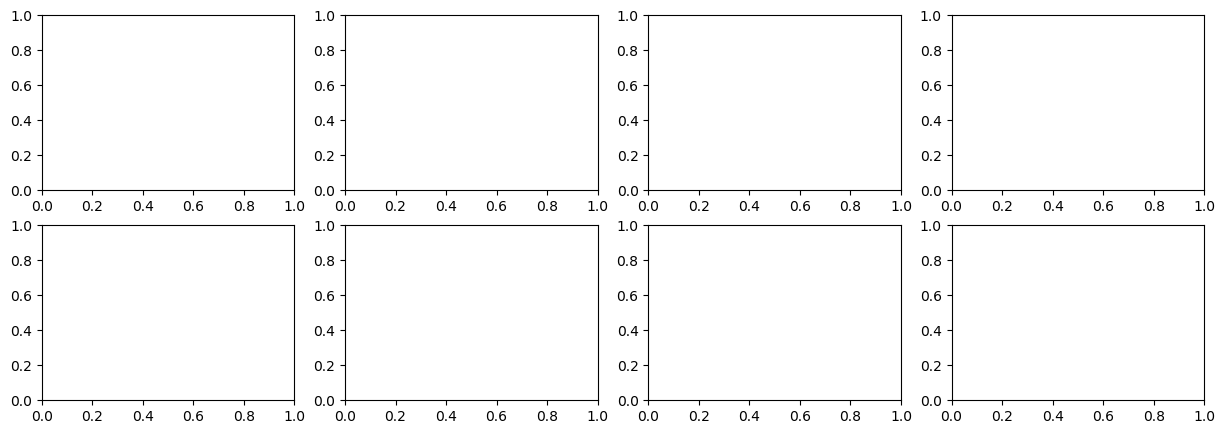

In [57]:
# sns.reset_defaults()
# TODO: Add title for the whole plot
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,5))
for subplot, v in zip(ax.ravel(), all_3_equal):
    # Get associated column (drop missing values)
    col = all_data.loc[all_data[v].notnull(), v]
    # Make one bin for each value in the variable's range
    bins = np.arange(col.min() - 0.5, col.max() + .5)
    # Plot histogram 
    subplot.hist(col, bins=bins)
    subplot.set_ylabel('Count')
    subplot.set_xlabel(v, fontsize=9)
    sns.despine()
    
# Delete the last subplot that we didn't use
ax[1,-1].axis('off')

# Increase spacing between plots    
fig.subplots_adjust(hspace=.5, wspace=.5)
 
plt.show()
plt.close()

Note that I chose a bin-width of one for these histograms, and that the x-axis corresponds to each variable's range. The counts are so low everywhere except at the lower end of the distribution that they are not visible. Thus, each of these variables is extremely right-skewed, and a log-transformation does make sense to ameliorate this skewness somewhat. 

We are now ready to perform these transformations. In order to also transform the variables just examined, we will explicitly pass their variable names as an argument.

In [ ]:
# Carry out the transformations
all_data, all_data_levels_old, log_diagnostics_trans = \
    transform_skewness(all_data, min_dummies=min_dummies, max_dummies=max_dummies, 
                       dry_run=False, take_log=all_3_equal)

The following might have too many categories, so let's examine them in more detail:

In [ ]:
for variable in ['emp_title', 'purpose', 'title']:
        print(variable, ':\n',
              all_data.loc[:, variable].value_counts().sort_values(ascending=False).head(20),
              '\n')

Delete title, keep purpose.  They both refer to what the loan is used for, but purpose is selected from a set of given categories, while title is filled in by the borrower.  Therefore, while title can have more details when the loan doesn't fit into any of the given categories, it would have to do natural language processing to extract the meaning.  Since this is beyond the scope of this analysis, we will only use purpose.

## Get rid of variables marked for deletion

In [ ]:
# all_data = all_data.drop(endogenous_2 + ['earliest_cr_line', 'last_credit_pull_d'], axis='columns')

Perform one-hot-encoding of categorical variables. Go through a list of all numerical variables to make sure they are not supposed to be categorical.

### EDA: Variation of default rate over time

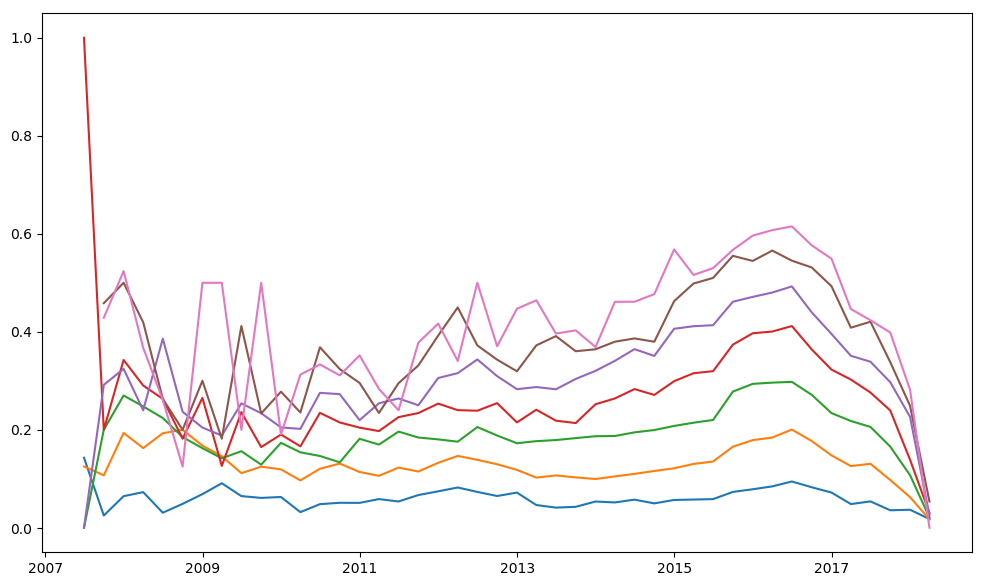

In [125]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(
    all_data.reset_index(level='id', drop=True) # Keep only date as index
    .loc[:,['default', 'grade']] # Select variables of interest
    .groupby('grade') # Group by loan grade
    .resample('Q').mean() # Take the monthly average
    .unstack(level='grade'));

2 things stand out from this plot: Firstly, There is much more variance for the 1st 3 years or so. This is probably due to the fact that the number of loans offered in the early years was lower, thus the quarterly average varies a lot more.

Secondly, about 3 years before the end of our sample period, the default rates begin to drops Suspiciously, eventually reaching 0. I double check that the date actually refers to the date the loan was issued rather than paid back, and that My calculation of the default rate excluded loans that are still current. Thus, the only remaining explanation is that some loans were paid back early. While this biases the above graph by artificially lowering the default rates of recent loans, this is only a problem for our analysis if we want to include the date.  In this case, we have to exclude loans whose issue date is less faraway from the present than the loan term.

In [115]:
(all_data.reset_index(level='id', drop=True) # Keep only date as index
    .loc[:,['default', 'grade']] # Select variables of interest
    .groupby('grade') # Group by loan grade
    .resample('MS').mean() # Take the monthly average
    .unstack(level='grade'))

default                                                            
grade              A         B         C         D         E         F         G
issue_d                                                                         
2007-06-01  0.142857  0.125000  0.000000  1.000000  0.000000       NaN       NaN
2007-07-01  0.000000  0.000000  0.133333  0.222222  0.250000  0.200000  0.000000
2007-08-01  0.055556  0.153846  0.500000  0.100000  0.200000  0.666667  0.666667
2007-09-01  0.000000  0.166667  0.083333  0.333333  0.500000  0.400000  0.333333
2007-10-01  0.000000  0.333333  0.222222  0.368421  0.350000  0.400000  0.666667
2007-11-01  0.000000  0.277778  0.370370  0.333333  0.307692  0.500000  0.250000
2007-12-01  0.166667  0.093750  0.239130  0.333333  0.321429  0.600000  0.500000
2008-01-01  0.111111  0.171875  0.263889  0.360000  0.400000  0.416667  0.500000
2008-02-01  0.000000  0.157303  0.236364  0.222222  0.214286  0.400000  0.333333
2008-03-01  0.085714  0.161290  0.241379  0.292683  0.156250  0.434783  0.333333
2008-04-01  0.041667  0.192982  0.218750  0.260870  0.428571  0.307692  0.300000
2008-05-01  0.047619  0.250000  0.222222  0.280000  0.357143  0.000000  0.000000
2008-06-01  0.000000  0.151515  0.235294  0.250000  0.250000  0.250000  0.000000
2008-07-01  0.086957  0.333333  0.128205  0.280000  0.333333  0.142857  0.000000
2008-08-01  0.000000  0.090909  0.166667  0.083333  0.100000  0.333333  0.250000
2008-09-01  0.000000  0.000000  0.333333  0.166667  0.200000  0.142857  0.000000
2008-10-01  0.142857  0.133333  0.179487  0.294118  0.111111  0.000000  0.333333
2008-11-01  0.060606  0.180556  0.145833  0.290323  0.300000  0.000000  1.000000
2008-12-01  0.041667  0.168831  0.164384  0.228571  0.133333  0.750000  0.000000
2009-01-01  0.098361  0.159420  0.136364  0.153846  0.250000  0.500000  1.000000
2009-02-01  0.061538  0.135135  0.144444  0.145161  0.200000  0.000000  0.600000
2009-03-01  0.111111  0.129032  0.142857  0.088235  0.147059  0.200000  0.250000
2009-04-01  0.053763  0.023810  0.166667  0.246575  0.194444  0.500000  0.333333
2009-05-01  0.078947  0.149123  0.135922  0.200000  0.277778  0.166667  0.000000
2009-06-01  0.063830  0.107143  0.168224  0.250000  0.444444  0.666667  0.200000
2009-07-01  0.078431  0.119658  0.166667  0.163636  0.235294  0.250000  0.500000
2009-08-01  0.027523  0.120000  0.141414  0.130435  0.166667  0.250000  0.500000
2009-09-01  0.076923  0.132911  0.088000  0.190476  0.300000  0.200000  0.500000
2009-10-01  0.078740  0.168478  0.184932  0.218750  0.161290  0.285714  0.333333
2009-11-01  0.067568  0.111111  0.184524  0.214876  0.241379  0.250000  0.125000
...              ...       ...       ...       ...       ...       ...       ...
2015-10-01  0.074150  0.167124  0.281620  0.371899  0.453663  0.546423  0.590643
2015-11-01  0.079051  0.175787  0.303021  0.395428  0.475821  0.517241  0.582524
2015-12-01  0.083669  0.195365  0.299102  0.425606  0.487361  0.562500  0.612245
2016-01-01  0.082345  0.164719  0.290122  0.408236  0.485215  0.584586  0.592857
2016-02-01  0.088809  0.186617  0.287347  0.400599  0.474877  0.596875  0.600000
2016-03-01  0.083174  0.194528  0.305745  0.396617  0.480415  0.537523  0.618729
2016-04-01  0.096022  0.203215  0.302930  0.410459  0.473349  0.542510  0.689266
2016-05-01  0.085776  0.209823  0.309582  0.422118  0.504469  0.535912  0.554622
2016-06-01  0.100151  0.190995  0.281601  0.402432  0.507160  0.555556  0.557692
2016-07-01  0.093713  0.192742  0.285552  0.362353  0.452849  0.544248  0.564885
2016-08-01  0.089986  0.178061  0.275510  0.377238  0.445631  0.540117  0.597015
2016-09-01  0.057118  0.153680  0.247844  0.350496  0.417241  0.502762  0.564356
2016-10-01  0.063978  0.139892  0.229055  0.315402  0.366215  0.470588  0.521277
2016-11-01  0.073740  0.155368  0.231415  0.327618  0.433540  0.553991  0.546667
2016-12-01  0.078093  0.148202  0.241862  0.325306  0.388158  0.475460  0.575472
2017-01-01  0.047112  0.128086  0.216501  0.

In [117]:
(all_data.reset_index(level='id', drop=True) # Keep only date as index
    .loc[:,['default', 'grade']] # Select variables of interest
    .groupby('grade') # Group by loan grade
    .resample('Q').count() # Take the monthly average
    .unstack(level='grade'))

default                                                      grade                                     \
grade             A        B        C        D       E       F      G        A        B        C        D       E   
issue_d                                                                                                             
2007-06-30      7.0      8.0      6.0      1.0     2.0     NaN    NaN      7.0      8.0      6.0      1.0     2.0   
2007-09-30     40.0     28.0     35.0     25.0    24.0    24.0   14.0     40.0     28.0     35.0     25.0    24.0   
2007-12-31     31.0     62.0    100.0     73.0    74.0    28.0   21.0     31.0     62.0    100.0     73.0    74.0   
2008-03-31    110.0    246.0    214.0    186.0   146.0    62.0   49.0    110.0    246.0    214.0    186.0   146.0   
2008-06-30     65.0    114.0    125.0     95.0    57.0    19.0   23.0     65.0    114.0    125.0     95.0    57.0   
2008-09-30     41.0     55.0     81.0     55.0    38.0    20.0    8.0     41.0     55.0     81.0     55.0    38.0   
2008-12-31    102.0    179.0    160.0     83.0    44.0    10.0    6.0    102.0    179.0    160.0     83.0    44.0   
2009-03-31    198.0    137.0    261.0    182.0    85.0    22.0   10.0    198.0    137.0    261.0    182.0    85.0   
2009-06-30    263.0    296.0    288.0    161.0    63.0    17.0   10.0    263.0    296.0    288.0    161.0    63.0   
2009-09-30    328.0    425.0    326.0    164.0    77.0    30.0   14.0    328.0    425.0    326.0    164.0    77.0   
2009-12-31    414.0    587.0    473.0    310.0    83.0    36.0   21.0    414.0    587.0    473.0    310.0    83.0   
2010-03-31    439.0    724.0    513.0    337.0   109.0    34.0   16.0    439.0    724.0    513.0    337.0   109.0   
2010-06-30    622.0    913.0    703.0    486.0   207.0    57.0   18.0    622.0    913.0    703.0    486.0   207.0   
2010-09-30    706.0   1022.0    786.0    563.0   341.0   105.0   45.0    706.0   1022.0    786.0    563.0   341.0   
2010-12-31   1063.0   1028.0    727.0    499.0   305.0   115.0   54.0   1063.0   1028.0    727.0    499.0   305.0   
2011-03-31   1110.0   1188.0    701.0    522.0   370.0   175.0   60.0   1110.0   1188.0    701.0    522.0   370.0   
2011-06-30   1249.0   1507.0    968.0    713.0   432.0   183.0   50.0   1249.0   1507.0    968.0    713.0   432.0   
2011-09-30   1647.0   1811.0   1037.0    756.0   420.0   160.0   45.0   1647.0   1811.0   1037.0    756.0   420.0   
2011-12-31   1748.0   2059.0   1236.0    805.0   517.0   204.0   48.0   1748.0   2059.0   1236.0    805.0   517.0   
2012-03-31   2335.0   2626.0   1497.0    933.0   469.0   169.0   47.0   2335.0   2626.0   1497.0    933.0   469.0   
2012-06-30   2418.0   3540.0   2228.0   1327.0   620.0   266.0   48.0   2418.0   3540.0   2228.0   1327.0   620.0   
2012-09-30   3084.0   5738.0   3675.0   2268.0   908.0   379.0   81.0   3084.0   5738.0   3675.0   2268.0   908.0   
2012-12-31   3064.0   6603.0   4475.0   2795.0  1188.0   501.0   85.0   3064.0   6603.0   4475.0   2795.0  1188.0   
2013-03-31   3298.0   8116.0   6629.0   2959.0  1149.0   497.0   56.0   3298.0   8116.0   6629.0   2959.0  1149.0   
2013-06-30   3669.0   9752.0   8586.0   4928.0  2211.0  1158.0  217.0   3669.0   9752.0   8586.0   4928.0  2211.0   
2013-09-30   3974.0  12080.0  10103.0   5605.0  2479.0  1299.0  283.0   3974.0  12080.0  10103.0   5605.0  2479.0   
2013-12-31   6662.0  13629.0  11023.0   6235.0  2635.0  1109.0  225.0   6662.0  13629.0  11023.0   6235.0  2635.0   
2014-03-31   6691.0  13271.0  12686.0   7376.0  3082.0  1006.0  232.0   6691.0  13271.0  12686.0   7376.0  3082.0   
2014-06-30   7488.0  14201.0  14189.0   9202.0  4191.0  1198.0  297.0   7488.0  14201.0  14189.0   9202.0  4191.0   
2014-09-30   8713.0  14237.0  14002.0   9526.0  4776.0  1733.0  562.0   8713.0  14237.0  14002.0   9526.0  4776.0   
2014-12-31  12861.0  17066.0  18626.0  10607.0  4932.0  1438.0  338.0  12861.0  17066.0  18626.0  10607.0  4932.0   
2015-03-31  14389.0  19837.0  2054

In [122]:
all_data.loan_status.unique()

array(['Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off',
       'Fully Paid', 'Charged Off', 'Default'], dtype=object)

In [124]:
# Make sure "fully paid" really means loan was repaid
(all_data.reset_index(level='id', drop=True) # Keep only date as index
    .loc[:,['loan_status']] 
    .resample('Q').apply(lambda x: (x=='Fully Paid').sum()))
    

,loan_status
issue_d,
2007-06-30,1
2007-09-30,71
2007-12-31,134
2008-03-31,485
2008-06-30,248
2008-09-30,158
2008-12-31,424
2009-03-31,682
2009-06-30,840


### label encoding

### imputing missing variables

# Predictive modeling
We will model loan default as dichotomous, either yes or no. While it is generally best to model a phenomenon at the most fine-ingrained measurement scale possible in order to minimize a model's variance, we unfortunately do not have all the required information to model default as the return on investment. Doing so would be advantageous, because it would take into account that earlier default is worse than later default. Thus, if the different features vary in terms of *when* the default that they can predict is most likely to occur, modeling the ROI would allow us to make more accurate decisions whether a specific customer is profitable.

Unfortunately, though, we don't have all the information to calculate the *time* value of payments received: Even though we do have the total amount of payments from each borrower, we don't know at what times these were received.  (Though we could try to impute these based on a number of pieces of information we do have available, the additional error introduced by this imputation is likely to outweigh any gains made from modeling default as a continuous event.) Therefore, I will model default as a dichotomous variable.

## Save or load data frame

In [ ]:
# Raise error, because we only want to execute the next 2 cells manually
raise Exception

In [ ]:
# Saving data frame
import pickle
with open('data_processed/all_data.pickle', 'wb') as pickled_file: # Use 'rb' instead for loading
    pickle.dump(all_data, pickled_file) #pickle file

In [ ]:
# Load packages and data
import pdb 
import glob
import copy
import math

import numpy as np
import pandas as pd
import scipy as sp
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import seaborn as sns
 
import missingno  # for visualizing missing data
import pickle

with open('data_processed/all_data.pickle', 'rb') as pickled_file: 
    all_data = pickle.load(pickled_file) # Un-pickle file